In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import pandas as pd
from helpers.training_methods import *
from helpers.visualizations_methods import *
from helpers.preprocessing_methods import *
from helpers.aequitas_methods import *
from helpers.mitigation_methods import *
from aequitas.flow.methods.inprocessing import FairlearnClassifier
from sklearn.metrics import classification_report
from IPython.display import display, HTML
from aequitas import Audit
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import openml
import warnings
import math
import gc
warnings.filterwarnings(action='ignore')

pip install 'aif360[inFairness]'


In [2]:
ml_ds = openml.datasets.get_dataset(43904)
df, * _ = ml_ds.get_data()
print(ml_ds.description[:500])
target = "bar"
list_of_disparities = ["fnr_disparity","fpr_disparity","ppr_disparity", "tnr_disparity"]

Law School Admissions (Binarized) 
 Survey among students attending law school in the U.S. in 1991. 
 The dataset was obtained from the R-package fairml. 
 The response variable has been changed to a binary version: Whether ugpa is greater than 3.
 The race1 variables has been binarized to labels white and non-white.


In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['lsat'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Lsat Distribution', fontsize=16)
plt.xlabel('Lsat', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [3]:
protected_attributes = ["race","fam_inc","lsat"]
def categorize_age(age):
    if age<60:
        return '0'
    if age>=60:
        return '1'
def categorize_lsat(lsat):
    if lsat<median:
        return 'Score <37'
    if lsat>=median:
        return 'Score >37'
df["age"] = df["age"].apply(categorize_age)
median = df["lsat"].median()
df["lsat"] = df["lsat"].apply(categorize_lsat)

# percentile_50 = np.percentile(df['lsat'], 50)
# df['lsat'] = np.where(df['lsat'] >= percentile_50, '<50%', '>50%')
df.rename(columns={ 'race1':'race'}, inplace=True)
df['race'].replace('black','other',inplace=True)
df['race'].replace('hisp','other',inplace=True)
df['race'].replace('asian','other',inplace=True)

df[target] = df[target].astype(int)
df["fam_inc"] = df["fam_inc"].astype(int)

gc.collect()

566

In [ ]:
def plot_attributes(dataset,attributes):
    fontsize = 10
    num_elements = len(attributes)
    num_cols = min(3, num_elements)  
    num_rows = math.ceil(num_elements / num_cols)
    
    fig_width = 7 * num_cols
    fig_height = 7 * num_rows
    
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height), sharey=True, gridspec_kw={'hspace':0.5})
    ax = ax.flatten()
    plt.subplots_adjust(hspace = 1.5)
    sns.set_style("whitegrid")
    for i, attribute in enumerate(attributes):
        g0 = sns.countplot(x=attribute, data=dataset, palette="hls", 
                      ax=ax[i],hue=target) # order=dataset[attribute].value_counts().index)
        g0.set_xlabel(attribute, fontsize=fontsize)
        g0.set_ylabel("Count", fontsize=fontsize)
plot_attributes(df,protected_attributes)

In [ ]:
corr = df_num.corr()
below_main_diagonal = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
mask = pd.isna(below_main_diagonal) 
plt.figure(figsize=(15, 10))
sns.heatmap(below_main_diagonal.fillna(0),
            annot=True, 
            cmap="Purples",
            center=0, 
            mask=mask,
            vmin=below_main_diagonal.min().min(), 
            vmax=below_main_diagonal.max().max()
            )

In [41]:
'''
Top 3 protected attributes: "race","age","lsat". Create new dataset with new columns containing the intersection of these attributes. Convert them to numerical.
'''
df_intersect = df.copy()
df_intersect["race/fam_inc"] = df_intersect["race"].astype(str) + " " +  df_intersect["fam_inc"].astype(str)
df_intersect["race/lsat"] = df_intersect["race"].astype(str) + " " + df_intersect["lsat"].astype(str)
df_intersect["lsat/fam_inc"] = df_intersect["lsat"].astype(str) + " " + df_intersect["fam_inc"].astype(str)

df_intersect.drop(["race", "lsat", "fam_inc"], axis=1, inplace=True)
protected_attributes_int = ["race/fam_inc","race/lsat","lsat/fam_inc"]


In [28]:
priv_orig, unpriv_orig= get_priv_and_unpriv_groups(protected_attribute=protected_attributes,data=df)
priv, unpriv= get_priv_and_unpriv_groups(protected_attribute=protected_attributes_int,data=df_intersect)

['age', 'lsat', 'gender', 'race', 'cluster', 'fulltime']
Attribute: age
{'0': 0, '1': 1}
Attribute: lsat
{'Score <37': 0, 'Score >37': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: race
{'other': 0, 'white': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=9, min_samples_leaf=16)
Accuracy score training:
0.9031
Accuracy score test:
0.8933
----------------------------------------



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0           race           other      0.76  0.82  0.59  0.45  0.15  0.41   
1           race           white      0.92  0.99  0.15  0.47  0.07  0.85   
2        fam_inc               1      0.72  0.81  0.43  0.61  0.17  0.57   
3        fam_inc               2      0.87  0.93  0.44  0.57  0.07  0.56   
4        fam_inc               3      0.89  0.97  0.38  0.37  0.09  0.62   
5        fam_inc               4      0.91  0.98  0.19  0.46  0.08  0.81   
6        fam_inc               5      0.91  0.97  0.28  0.56  0.07  0.72   
7           lsat       Score <37      0.83  0.93  0.38  0.46  0.13  0.62   
8           lsat       Score >37      0.95  1.00  0.11  0.45  0.05  0.89   

    fnr   npv  precision   ppr  pprev  prev  
0  0.18  0.55       0.85  0.12   0.71  0.73  
1  0.01  0.53       0.93  0.88   0.98  0.92  
2  0.19  0.39       0.83  0.02   0.75  0.77  
3  0.07  0.43       0.93  0.09   0.88  0.89  
4  0.03  0.63       0.91  0.36   0.92  0.87  
5  0.02  0.54       0.92  0.45   0.97  0.91  
6  0.03  0.44       0.93  0.08   0.95  0.91  
7  0.07  0.54       0.87  0.44   0.87  0.82  
8  0.00  0.55       0.95  0.56   0.99  0.95

Majority class for:  race  is: white
Majority class for:  fam_inc  is: 4
Majority class for:  lsat  is: Score >37
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0           race           other           2.08          14.63           0.96   
1           race           white           1.00           1.00           1.00   
2        fam_inc               1           2.19          11.49           1.33   
3        fam_inc               2           0.91           4.38           1.23   
4        fam_inc               3           1.16           2.04           0.81   
5        fam_inc               4           1.00           1.00           1.00   
6        fam_inc               5           0.83           1.90           1.21   
7           lsat       Score <37           2.82          14.95           1.01   
8           lsat       Score >37           1.00           1.00           1.00   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           0.48           1.03           0.13             0.73   
1           1.00           1.00           1.00             1.00   
2           0.71           0.72           0.04             0.78   
3           0.69           0.80           0.20             0.91   
4           0.77           1.16           0.78             0.95   
5           1.00           1.00           1.00             1.00   
6           0.90           0.82           0.18             0.98   
7           0.70           0.99           0.77             0.88   
8           1.00           1.00           1.00             1.00   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.91           3.98           0.83  
1                 1.00           1.00           1.00  
2                 0.90           2.22           0.82  
3                 1.01           2.30           0.94  
4                 0.99           1.96           0.98  
5                 1.00           1.00           1.00  
6                 1.01           1.43           0.98  
7                 0.91           3.56           0.93  
8                 1.00           1.00           1.00

dict_keys(['race', 'fam_inc', 'lsat'])
         fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race           14.6300         0.4800           0.13         3.9800
fam_inc         4.9525         0.7675           0.30         1.9775
lsat           14.9500         0.7000           0.77         3.5600
Overall average for fnr_disparity:  11.511
Overall average for fpr_disparity:  0.649
Overall average for ppr_disparity:  0.400
Overall average for tnr_disparity:  3.172


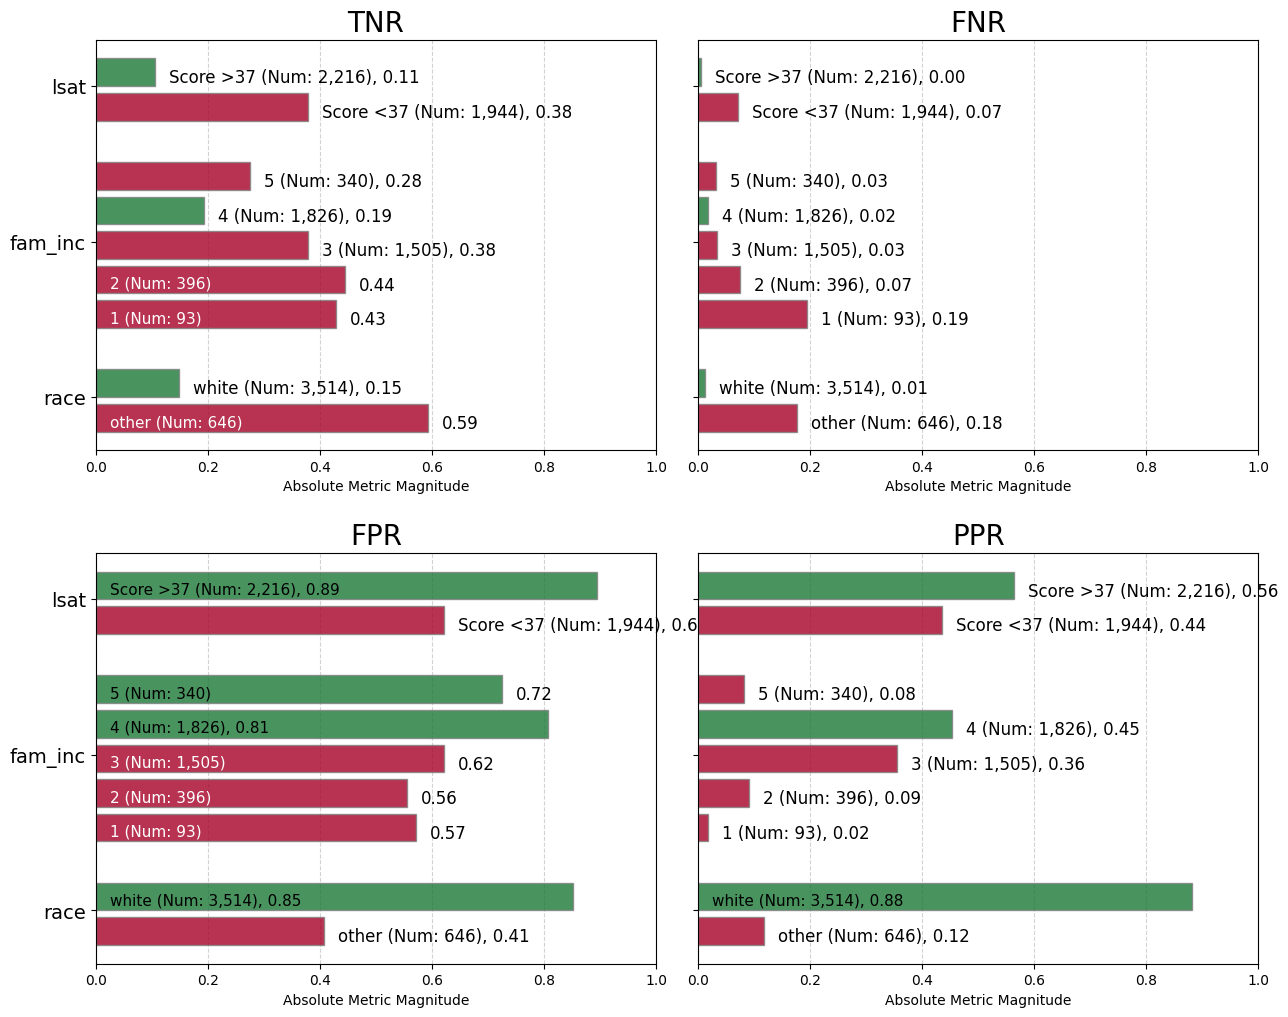

<Figure size 640x480 with 0 Axes>

In [43]:
x_test, y_test, y_predicted_dict, metrics_dict = split_and_train(df,protected_attributes,target,[])
df_test= calc_fairness_report(x_test, y_test, y_predicted_dict['DecisionTree'], target, protected_attributes, list_of_disparities, priv_orig,display_disp=True)

['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other Score <37': 0, 'other Score >37': 1, 'white Score <37': 2, 'white Score >37': 3}
Attribute: lsat/fam_inc
{'Score <37 1': 0, 'Score <37 2': 1, 'Score <37 3': 2, 'Score <37 4': 3, 'Score <37 5': 4, 'Score >37 1': 5, 'Score >37 2': 6, 'Score >37 3': 7, 'Score >37 4': 8, 'Score >37 5': 9}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=9, min_samples_leaf=16)
Accuracy score training:
0.9046
Accuracy score test:
0.8875
----------------------------------------



attribute_name  attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc          other 1      0.61  0.62  0.57  0.60  0.23  0.43   
1    race/fam_inc          other 2      0.75  0.79  0.63  0.56  0.11  0.37   
2    race/fam_inc          other 3      0.77  0.83  0.65  0.38  0.16  0.35   
3    race/fam_inc          other 4      0.80  0.91  0.45  0.38  0.17  0.55   
4    race/fam_inc          other 5      0.74  0.73  0.80  0.60  0.06  0.20   
5    race/fam_inc          white 1      0.83  0.95  0.14  0.67  0.14  0.86   
6    race/fam_inc          white 2      0.93  0.98  0.17  0.57  0.06  0.83   
7    race/fam_inc          white 3      0.91  0.99  0.19  0.36  0.08  0.81   
8    race/fam_inc          white 4      0.92  0.99  0.10  0.55  0.07  0.90   
9    race/fam_inc          white 5      0.92  0.99  0.17  0.50  0.07  0.83   
10      race/lsat  other Score <37      0.71  0.74  0.64  0.44  0.20  0.36   
11      race/lsat  other Score >37      0.90  0.97  0.13  0.71  0.07  0.87   
12      race/lsat  white Score <37      0.87  0.97  0.17  0.50  0.12  0.83   
13      race/lsat  white Score >37      0.95  1.00  0.10  0.33  0.04  0.90   
14   lsat/fam_inc      Score <37 1      0.67  0.73  0.50  0.59  0.20  0.50   
15   lsat/fam_inc      Score <37 2      0.79  0.87  0.48  0.53  0.13  0.52   
16   lsat/fam_inc      Score <37 3      0.83  0.93  0.45  0.38  0.13  0.55   
17   lsat/fam_inc      Score <37 4      0.85  0.96  0.24  0.47  0.13  0.76   
18   lsat/fam_inc      Score <37 5      0.83  0.92  0.28  0.64  0.11  0.72   
19   lsat/fam_inc      Score >37 1      0.85  0.96  0.00  1.00  0.12  1.00   
20   lsat/fam_inc      Score >37 2      0.97  0.98  0.00  1.00  0.02  1.00   
21   lsat/fam_inc      Score >37 3      0.95  1.00  0.08  0.25  0.05  0.92   
22   lsat/fam_inc      Score >37 4      0.95  1.00  0.11  0.40  0.05  0.89   
23   lsat/fam_inc      Score >37 5      0.96  1.00  0.27  0.25  0.04  0.73   

     fnr   npv  precision   ppr  pprev  prev  
0   0.38  0.40       0.77  0.01   0.57  0.70  
1   0.21  0.44       0.89  0.02   0.70  0.79  
2   0.17  0.62       0.84  0.05   0.68  0.69  
3   0.09  0.62       0.83  0.04   0.82  0.75  
4   0.27  0.40       0.94  0.00   0.63  0.81  
5   0.05  0.33       0.86  0.01   0.94  0.85  
6   0.02  0.43       0.94  0.07   0.97  0.93  
7   0.01  0.64       0.92  0.31   0.97  0.90  
8   0.01  0.45       0.93  0.42   0.98  0.92  
9   0.01  0.50       0.93  0.08   0.97  0.92  
10  0.26  0.56       0.80  0.07   0.61  0.66  
11  0.03  0.29       0.93  0.05   0.96  0.92  
12  0.03  0.50       0.88  0.36   0.95  0.87  
13  0.00  0.67       0.96  0.52   0.99  0.95  
14  0.27  0.41       0.80  0.01   0.67  0.73  
15  0.13  0.47       0.87  0.04   0.80  0.80  
16  0.07  0.62       0.87  0.17   0.85  0.79  
17  0.04  0.53       0.87  0.18   0.93  0.85  
18  0.08  0.36       0.89  0.03   0.89  0.86  
19  0.04  0.00       0.88  0.01   0.96  0.89  
20  0.02  0.00       0.98  0.05   0.98  0.98  
21  0.00  0.75       0.95  0.18   0.99  0.95  
22  0.00  0.60       0.95  0.28   0.99  0.95  
23  0.00  0.75       0.96  0.05   0.98  0.95

Majority class for:  race/fam_inc  is: white 4
Majority class for:  race/lsat  is: white Score >37
Majority class for:  lsat/fam_inc  is: Score >37 4
[]


attribute_name  attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc          other 1           3.28          35.70   
1    race/fam_inc          other 2           1.56          20.33   
2    race/fam_inc          other 3           2.27          16.46   
3    race/fam_inc          other 4           2.37           8.65   
4    race/fam_inc          other 5           0.84          25.96   
5    race/fam_inc          white 1           1.94           4.76   
6    race/fam_inc          white 2           0.82           1.54   
7    race/fam_inc          white 3           1.14           1.11   
8    race/fam_inc          white 4           1.00           1.00   
9    race/fam_inc          white 5           0.93           1.32   
10      race/lsat  other Score <37           4.62         100.19   
11      race/lsat  other Score >37           1.68          11.44   
12      race/lsat  white Score <37           2.64          10.23   
13      race/lsat  white Score >37           1.00           1.00   
14   lsat/fam_inc      Score <37 1           4.30          69.33   
15   lsat/fam_inc      Score <37 2           2.69          34.03   
16   lsat/fam_inc      Score <37 3           2.78          17.94   
17   lsat/fam_inc      Score <37 4           2.63           9.74   
18   lsat/fam_inc      Score <37 5           2.39          20.95   
19   lsat/fam_inc      Score >37 1           2.42          10.67   
20   lsat/fam_inc      Score >37 2           0.35           4.31   
21   lsat/fam_inc      Score >37 3           1.06           0.38   
22   lsat/fam_inc      Score >37 4           1.00           1.00   
23   lsat/fam_inc      Score >37 5           0.81           1.27   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.09           0.48           0.89           0.02   
1            1.02           0.41           0.97           0.06   
2            0.68           0.39           1.39           0.11   
3            0.68           0.61           1.39           0.09   
4            1.09           0.22           0.89           0.01   
5            1.21           0.95           0.74           0.03   
6            1.04           0.93           0.96           0.16   
7            0.65           0.90           1.43           0.74   
8            1.00           1.00           1.00           1.00   
9            0.91           0.93           1.12           0.19   
10           1.32           0.40           0.84           0.14   
11           2.14           0.97           0.43           0.09   
12           1.50           0.92           0.75           0.70   
13           1.00           1.00           1.00           1.00   
14           1.48           0.56           0.68           0.04   
15           1.34           0.59           0.78           0.16   
16           0.94           0.61           1.04           0.63   
17           1.18           0.85           0.88           0.65   
18           1.61           0.81           0.60           0.11   
19           2.50           1.12           0.00           0.02   
20           2.50           1.12           0.00           0.17   
21           0.62           1.03           1.25           0.66   
22           1.00           1.00           1.00           1.00   
23           0.62           0.81           1.25           0.19   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.58                 0.83           5.58           0.63  
1              0.71                 0.96           6.15           0.79  
2              0.69                 0.90           6.31           0.84  
3              0.83                 0.90           4.44           0.92  
4              0.64                 1.01           7.82           0.73  
5              0.95                 0.93           1.40           0.96  
6              0.99                 1.01           1.63           0.99  
7              0.99                 0.99           1.89           1

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc      12.870000       0.646667       0.156667       4.094444
race/lsat         40.620000       0.763333       0.310000       3.080000
lsat/fam_inc      18.735556       0.833333       0.292222       2.417778
Overall average for fnr_disparity:  24.075
Overall average for fpr_disparity:  0.748
Overall average for ppr_disparity:  0.253
Overall average for tnr_disparity:  3.197


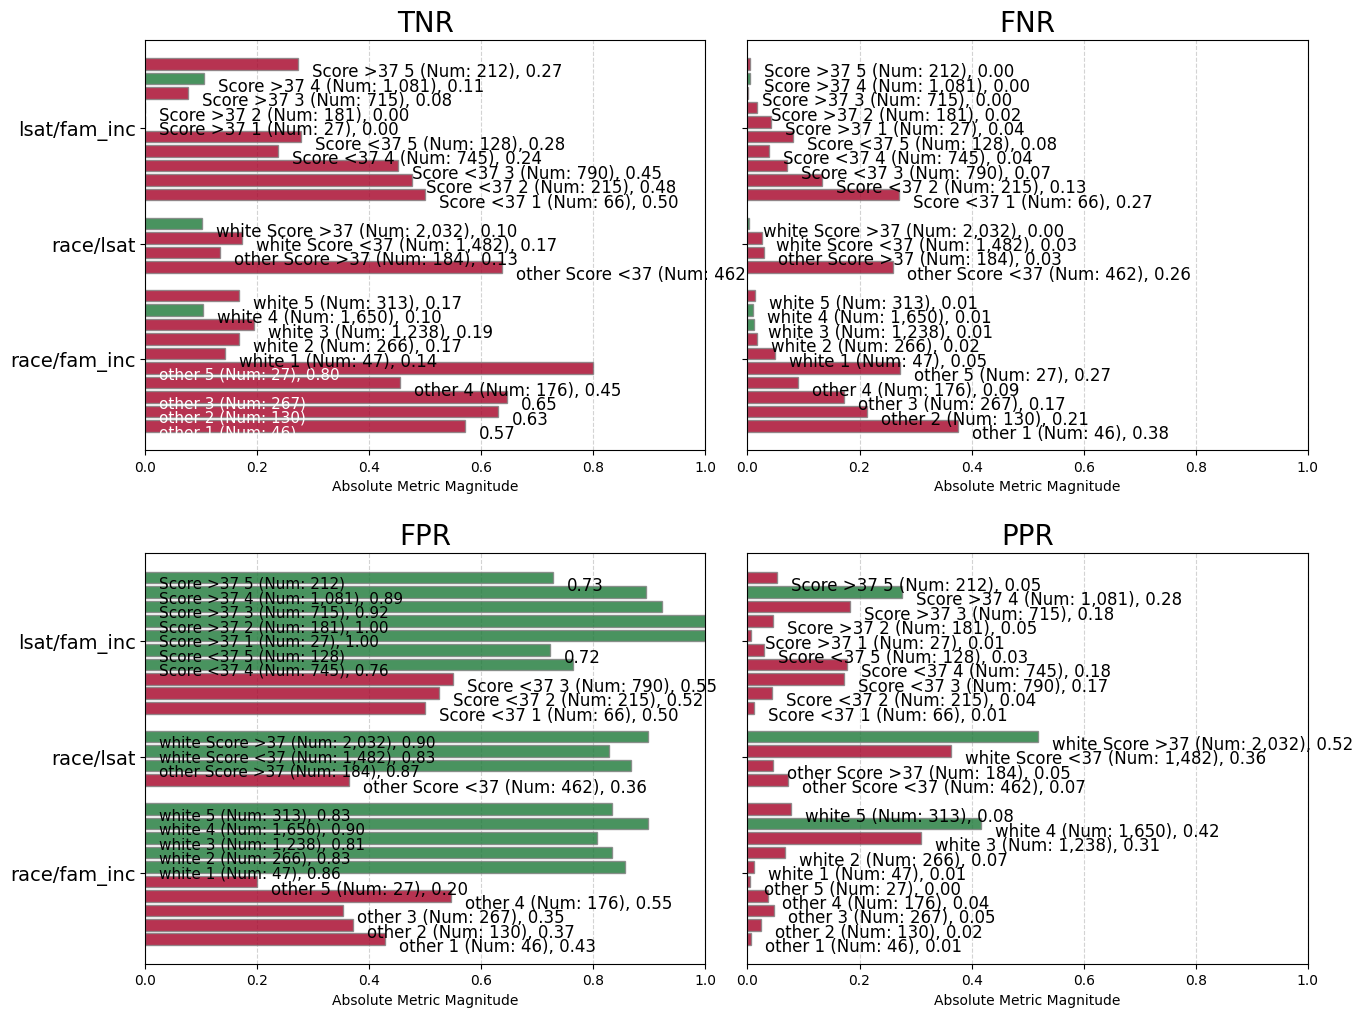

<Figure size 640x480 with 0 Axes>

In [44]:

"""
Train and calculate fariness metrics for the dataset obtained by the intersection of protected attributes.
"""
x_test_int, y_test_int, y_predicted_dict_int, metrics_dict_int = split_and_train(df_intersect, protected_attributes_int,target,)
df_test= calc_fairness_report(x_test_int, y_test_int, y_predicted_dict['DecisionTree'], target, protected_attributes_int, list_of_disparities, priv,display_disp=True)

['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other Score <37': 0, 'other Score >37': 1, 'white Score <37': 2, 'white Score >37': 3}
Attribute: lsat/fam_inc
{'Score <37 1': 0, 'Score <37 2': 1, 'Score <37 3': 2, 'Score <37 4': 3, 'Score <37 5': 4, 'Score >37 1': 5, 'Score >37 2': 6, 'Score >37 3': 7, 'Score >37 4': 8, 'Score >37 5': 9}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=10)
Accuracy score training:
0.9810
Accuracy score test:
0.9726
----------------------------------------



attribute_name  attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc          other 1      0.63  0.66  0.57  0.58  0.22  0.43   
1    race/fam_inc          other 2      0.95  0.96  0.75  0.62  0.01  0.25   
2    race/fam_inc          other 3      1.00  1.00  1.00  0.00  0.00  0.00   
3    race/fam_inc          other 4      1.00  1.00  1.00  0.00  0.00  0.00   
4    race/fam_inc          other 5      0.96  1.00  0.94  0.00  0.09  0.06   
5    race/fam_inc          white 1      0.98   NaN  0.98  0.00  1.00  0.02   
6    race/fam_inc          white 2      0.97  0.98  0.88  0.15  0.01  0.12   
7    race/fam_inc          white 3      0.99  1.00  0.94  0.02  0.01  0.06   
8    race/fam_inc          white 4      0.96  1.00  0.70  0.06  0.03  0.30   
9    race/fam_inc          white 5      0.96  1.00  0.46  0.08  0.04  0.54   
10      race/lsat  other Score <37      0.95  0.96  0.91  0.20  0.02  0.09   
11      race/lsat  other Score >37      0.99  1.00  0.00   NaN  0.01  1.00   
12      race/lsat  white Score <37      0.99  1.00  0.95  0.03  0.01  0.05   
13      race/lsat  white Score >37      0.96  1.00  0.68  0.06  0.04  0.32   
14   lsat/fam_inc      Score <37 1      0.74  0.58  0.85  0.24  0.29  0.15   
15   lsat/fam_inc      Score <37 2      0.95  0.96  0.86  0.43  0.01  0.14   
16   lsat/fam_inc      Score <37 3      0.99  1.00  0.96  0.01  0.01  0.04   
17   lsat/fam_inc      Score <37 4      1.00  1.00  1.00  0.01  0.00  0.00   
18   lsat/fam_inc      Score <37 5      0.98  1.00  0.90  0.00  0.03  0.10   
19   lsat/fam_inc      Score >37 1      0.96  1.00  0.95  0.00  0.14  0.05   
20   lsat/fam_inc      Score >37 2      0.99  1.00  0.88  0.00  0.01  0.12   
21   lsat/fam_inc      Score >37 3      0.99  1.00  0.93  0.05  0.00  0.07   
22   lsat/fam_inc      Score >37 4      0.95  0.99  0.56  0.08  0.05  0.44   
23   lsat/fam_inc      Score >37 5      0.94  1.00  0.00  1.00  0.05  1.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.34  0.42       0.78  0.01   0.59  0.70  
1   0.04  0.38       0.99  0.03   0.94  0.97  
2   0.00  1.00       1.00  0.07   0.91  0.91  
3   0.00  1.00       1.00  0.04   0.93  0.93  
4   0.00  1.00       0.91  0.00   0.41  0.37  
5    NaN  1.00       0.00  0.00   0.02  0.00  
6   0.02  0.85       0.99  0.06   0.90  0.90  
7   0.00  0.98       0.99  0.30   0.90  0.90  
8   0.00  0.94       0.97  0.41   0.92  0.90  
9   0.00  0.92       0.96  0.08   0.96  0.92  
10  0.04  0.80       0.98  0.10   0.83  0.85  
11  0.00   NaN       0.99  0.05   1.00  0.99  
12  0.00  0.97       0.99  0.35   0.87  0.87  
13  0.00  0.94       0.96  0.50   0.93  0.90  
14  0.42  0.76       0.71  0.01   0.32  0.39  
15  0.04  0.57       0.99  0.05   0.90  0.93  
16  0.00  0.99       0.99  0.18   0.87  0.86  
17  0.00  0.99       1.00  0.18   0.91  0.91  
18  0.00  1.00       0.97  0.03   0.79  0.77  
19  0.00  1.00       0.86  0.00   0.26  0.22  
20  0.00  1.00       0.99  0.04   0.92  0.91  
21  0.00  0.95       1.00  0.18   0.94  0.94  
22  0.01  0.92       0.95  0.27   0.93  0.89  
23  0.00  0.00       0.95  0.06   1.00  0.95

Majority class for:  race/fam_inc  is: white 4
Majority class for:  race/lsat  is: white Score >37
Majority class for:  lsat/fam_inc  is: Score >37 4
[]


attribute_name  attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc          other 1           6.64          72.68   
1    race/fam_inc          other 2           0.24           8.39   
2    race/fam_inc          other 3           0.00           0.00   
3    race/fam_inc          other 4           0.00           0.00   
4    race/fam_inc          other 5           2.72           0.00   
5    race/fam_inc          white 1          29.88            NaN   
6    race/fam_inc          white 2           0.38           3.52   
7    race/fam_inc          white 3           0.19           0.57   
8    race/fam_inc          white 4           1.00           1.00   
9    race/fam_inc          white 5           1.29           0.73   
10      race/lsat  other Score <37           0.45           8.26   
11      race/lsat  other Score >37           0.31           0.00   
12      race/lsat  white Score <37           0.20           0.94   
13      race/lsat  white Score >37           1.00           1.00   
14   lsat/fam_inc      Score <37 1           5.66          68.04   
15   lsat/fam_inc      Score <37 2           0.20           7.20   
16   lsat/fam_inc      Score <37 3           0.12           0.24   
17   lsat/fam_inc      Score <37 4           0.00           0.24   
18   lsat/fam_inc      Score <37 5           0.59           0.00   
19   lsat/fam_inc      Score >37 1           2.83           0.00   
20   lsat/fam_inc      Score >37 2           0.24           0.00   
21   lsat/fam_inc      Score >37 3           0.09           0.48   
22   lsat/fam_inc      Score >37 4           1.00           1.00   
23   lsat/fam_inc      Score >37 5           1.03           0.80   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0           10.42           1.43           0.45           0.02   
1           11.25           0.83           0.40           0.08   
2            0.00           0.00           1.06           0.16   
3            0.00           0.00           1.06           0.11   
4            0.00           0.20           1.06           0.01   
5            0.00           0.07           1.06           0.00   
6            2.67           0.38           0.90           0.16   
7            0.44           0.18           1.03           0.73   
8            1.00           1.00           1.00           1.00   
9            1.50           1.81           0.97           0.20   
10           3.33           0.27           0.85           0.20   
11            NaN           3.11            NaN           0.10   
12           0.53           0.15           1.03           0.69   
13           1.00           1.00           1.00           1.00   
14           2.89           0.34           0.83           0.02   
15           5.07           0.32           0.62           0.19   
16           0.11           0.09           1.08           0.68   
17           0.17           0.00           1.08           0.67   
18           0.00           0.23           1.09           0.10   
19           0.00           0.11           1.09           0.01   
20           0.00           0.28           1.09           0.17   
21           0.56           0.16           1.04           0.67   
22           1.00           1.00           1.00           1.00   
23          11.83           2.27           0.00           0.21   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.64                 0.80           0.82           0.66  
1              1.02                 1.03           1.07           0.96  
2              0.99                 1.03           1.43           1.00  
3              1.00                 1.03           1.43           1.00  
4              0.44                 0.94           1.34           1.00  
5              0.02                 0.00           1.40            NaN  
6              0.97                 1.02           1.26           0.99  
7              0.98                 1.03           1.35           1

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc      10.736250       0.544444       0.163333       1.194444
race/lsat          3.066667       1.176667       0.330000       0.916667
lsat/fam_inc       8.555556       0.422222       0.302222       1.453333
Overall average for fnr_disparity:  7.453
Overall average for fpr_disparity:  0.714
Overall average for ppr_disparity:  0.265
Overall average for tnr_disparity:  1.188


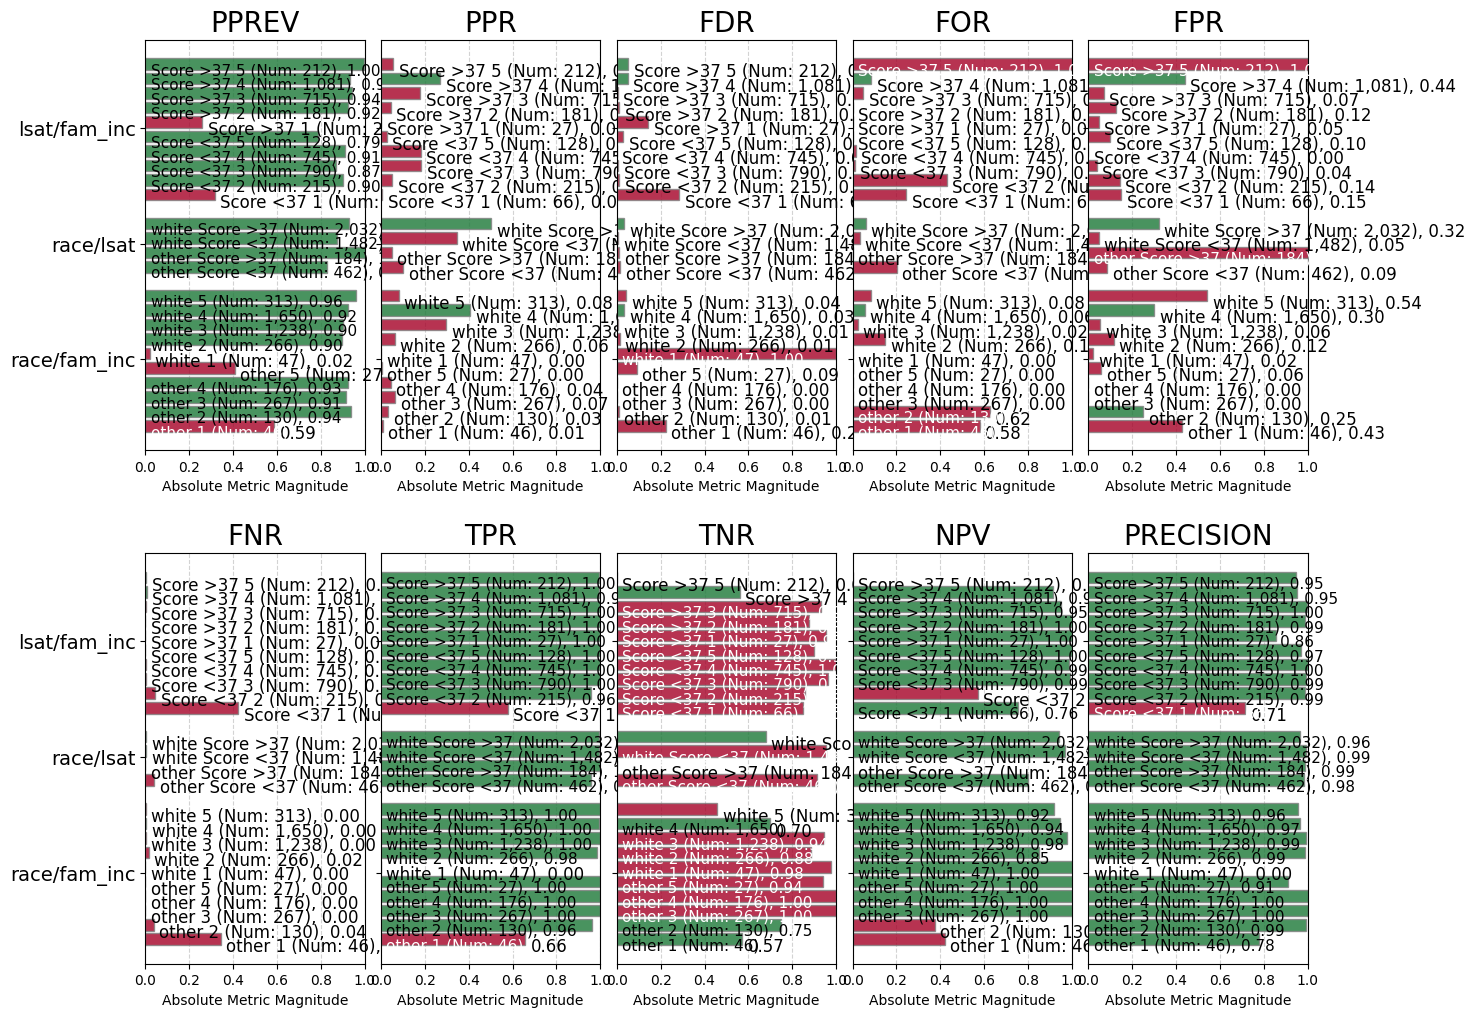

<Figure size 640x480 with 0 Axes>

In [45]:
'''
1: Massaging method (Flips selected labels to reduce prevalence disparity between groups), train and calculate metrics.
'''
#transform data
data_to_transform = prep_massaging(df_intersect, protected_attributes_int, target)
#train on the transformed dataset
x_test_ms, y_test_ms, y_predicted_dict_transformed, metrics_ms_dict = split_and_train(data_to_transform,protected_attributes_int,target)
df_test_transformed =calc_fairness_report(x_test_ms, y_test_ms, y_predicted_dict_transformed["DecisionTree"],target,protected_attributes_int,list_of_disparities, priv, display_disp=True)

[INFO] 2024-12-07 20:32:34 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-12-07 20:32:34 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-12-07 20:32:34 methods.preprocessing.PrevalenceSampling - Original group white 5 size: 1541


INFO:methods.preprocessing.PrevalenceSampling:Original group white 5 size: 1541


[INFO] 2024-12-07 20:32:34 methods.preprocessing.PrevalenceSampling - Final group white 5 size: 1620


INFO:methods.preprocessing.PrevalenceSampling:Final group white 5 size: 1620


[INFO] 2024-12-07 20:32:34 methods.preprocessing.PrevalenceSampling - Original group white 4 size: 8199


INFO:methods.preprocessing.PrevalenceSampling:Original group white 4 size: 8199


[INFO] 2024-12-07 20:32:34 methods.preprocessing.PrevalenceSampling - Final group white 4 size: 8514


INFO:methods.preprocessing.PrevalenceSampling:Final group white 4 size: 8514


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group white 3 size: 6131


INFO:methods.preprocessing.PrevalenceSampling:Original group white 3 size: 6131


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group white 3 size: 6303


INFO:methods.preprocessing.PrevalenceSampling:Final group white 3 size: 6303


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group other 3 size: 1338


INFO:methods.preprocessing.PrevalenceSampling:Original group other 3 size: 1338


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group other 3 size: 3574


INFO:methods.preprocessing.PrevalenceSampling:Final group other 3 size: 3574


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group other 4 size: 980


INFO:methods.preprocessing.PrevalenceSampling:Original group other 4 size: 980


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group other 4 size: 2005


INFO:methods.preprocessing.PrevalenceSampling:Final group other 4 size: 2005


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group white 1 size: 209


INFO:methods.preprocessing.PrevalenceSampling:Original group white 1 size: 209


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group white 1 size: 212


INFO:methods.preprocessing.PrevalenceSampling:Final group white 1 size: 212


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group white 2 size: 1413


INFO:methods.preprocessing.PrevalenceSampling:Original group white 2 size: 1413


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group white 2 size: 1464


INFO:methods.preprocessing.PrevalenceSampling:Final group white 2 size: 1464


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group other 5 size: 152


INFO:methods.preprocessing.PrevalenceSampling:Original group other 5 size: 152


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group other 5 size: 272


INFO:methods.preprocessing.PrevalenceSampling:Final group other 5 size: 272


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group other 2 size: 625


INFO:methods.preprocessing.PrevalenceSampling:Original group other 2 size: 625


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group other 2 size: 1823


INFO:methods.preprocessing.PrevalenceSampling:Final group other 2 size: 1823


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group other 1 size: 212


INFO:methods.preprocessing.PrevalenceSampling:Original group other 1 size: 212


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group other 1 size: 635


INFO:methods.preprocessing.PrevalenceSampling:Final group other 1 size: 635


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group white Score >37 size: 10342


INFO:methods.preprocessing.PrevalenceSampling:Original group white Score >37 size: 10342


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group white Score >37 size: 11352


INFO:methods.preprocessing.PrevalenceSampling:Final group white Score >37 size: 11352


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group white Score <37 size: 7771


INFO:methods.preprocessing.PrevalenceSampling:Original group white Score <37 size: 7771


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group white Score <37 size: 12064


INFO:methods.preprocessing.PrevalenceSampling:Final group white Score <37 size: 12064


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group other Score <37 size: 5679


INFO:methods.preprocessing.PrevalenceSampling:Original group other Score <37 size: 5679


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group other Score <37 size: 13098


INFO:methods.preprocessing.PrevalenceSampling:Final group other Score <37 size: 13098


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group other Score >37 size: 2630


INFO:methods.preprocessing.PrevalenceSampling:Original group other Score >37 size: 2630


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group other Score >37 size: 2852


INFO:methods.preprocessing.PrevalenceSampling:Final group other Score >37 size: 2852


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Instantiating a PrevalenceSampling preprocessing method.


INFO:methods.preprocessing.PrevalenceSampling:Instantiating a PrevalenceSampling preprocessing method.


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Transforming data.


INFO:methods.preprocessing.PrevalenceSampling:Transforming data.


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score >37 5 size: 1375


INFO:methods.preprocessing.PrevalenceSampling:Original group Score >37 5 size: 1375


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score >37 5 size: 2694


INFO:methods.preprocessing.PrevalenceSampling:Final group Score >37 5 size: 2694


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score <37 4 size: 7672


INFO:methods.preprocessing.PrevalenceSampling:Original group Score <37 4 size: 7672


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score <37 4 size: 7949


INFO:methods.preprocessing.PrevalenceSampling:Final group Score <37 4 size: 7949


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score >37 3 size: 4772


INFO:methods.preprocessing.PrevalenceSampling:Original group Score >37 3 size: 4772


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score >37 3 size: 7079


INFO:methods.preprocessing.PrevalenceSampling:Final group Score >37 3 size: 7079


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score >37 4 size: 6392


INFO:methods.preprocessing.PrevalenceSampling:Original group Score >37 4 size: 6392


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score >37 4 size: 8679


INFO:methods.preprocessing.PrevalenceSampling:Final group Score >37 4 size: 8679


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score <37 3 size: 10716


INFO:methods.preprocessing.PrevalenceSampling:Original group Score <37 3 size: 10716


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score <37 3 size: 11171


INFO:methods.preprocessing.PrevalenceSampling:Final group Score <37 3 size: 11171


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score <37 1 size: 1384


INFO:methods.preprocessing.PrevalenceSampling:Original group Score <37 1 size: 1384


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score <37 1 size: 1462


INFO:methods.preprocessing.PrevalenceSampling:Final group Score <37 1 size: 1462


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score <37 2 size: 4289


INFO:methods.preprocessing.PrevalenceSampling:Original group Score <37 2 size: 4289


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score <37 2 size: 4527


INFO:methods.preprocessing.PrevalenceSampling:Final group Score <37 2 size: 4527


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score >37 2 size: 1397


INFO:methods.preprocessing.PrevalenceSampling:Original group Score >37 2 size: 1397


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score >37 2 size: 2537


INFO:methods.preprocessing.PrevalenceSampling:Final group Score >37 2 size: 2537


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score <37 5 size: 1101


INFO:methods.preprocessing.PrevalenceSampling:Original group Score <37 5 size: 1101


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score <37 5 size: 1351


INFO:methods.preprocessing.PrevalenceSampling:Final group Score <37 5 size: 1351


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Original group Score >37 1 size: 268


INFO:methods.preprocessing.PrevalenceSampling:Original group Score >37 1 size: 268


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Final group Score >37 1 size: 405


INFO:methods.preprocessing.PrevalenceSampling:Final group Score >37 1 size: 405


[INFO] 2024-12-07 20:32:35 methods.preprocessing.PrevalenceSampling - Data transformed.


INFO:methods.preprocessing.PrevalenceSampling:Data transformed.


['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other Score <37': 0, 'other Score >37': 1, 'white Score <37': 2, 'white Score >37': 3}
Attribute: lsat/fam_inc
{'Score <37 1': 0, 'Score <37 2': 1, 'Score <37 3': 2, 'Score <37 4': 3, 'Score <37 5': 4, 'Score >37 1': 5, 'Score >37 2': 6, 'Score >37 3': 7, 'Score >37 4': 8, 'Score >37 5': 9}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=10)
Accuracy score training:
0.9222
Accuracy score test:
0.9114
----------------------------------------



attribute_name  attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc          other 1      0.94  1.00  0.16  0.00  0.07  0.84   
1    race/fam_inc          other 2      0.94  1.00  0.15  0.10  0.06  0.85   
2    race/fam_inc          other 3      0.93  0.99  0.12  0.46  0.06  0.88   
3    race/fam_inc          other 4      0.94  0.99  0.26  0.32  0.05  0.74   
4    race/fam_inc          other 5      0.95  0.97  0.20  0.83  0.02  0.80   
5    race/fam_inc          white 1      0.90  0.93  0.80  0.25  0.06  0.20   
6    race/fam_inc          white 2      0.92  0.97  0.63  0.19  0.07  0.37   
7    race/fam_inc          white 3      0.86  0.96  0.24  0.46  0.12  0.76   
8    race/fam_inc          white 4      0.91  0.98  0.37  0.33  0.08  0.63   
9    race/fam_inc          white 5      0.92  0.96  0.58  0.36  0.05  0.42   
10      race/lsat  other Score <37      0.93  1.00  0.13  0.10  0.07  0.87   
11      race/lsat  other Score >37      0.95  0.98  0.27  0.57  0.04  0.73   
12      race/lsat  white Score <37      0.87  0.97  0.33  0.36  0.11  0.67   
13      race/lsat  white Score >37      0.91  0.97  0.43  0.35  0.07  0.57   
14   lsat/fam_inc      Score <37 1      0.92  0.99  0.38  0.19  0.07  0.62   
15   lsat/fam_inc      Score <37 2      0.93  0.99  0.40  0.16  0.07  0.60   
16   lsat/fam_inc      Score <37 3      0.89  0.98  0.20  0.36  0.10  0.80   
17   lsat/fam_inc      Score <37 4      0.91  0.99  0.24  0.34  0.08  0.76   
18   lsat/fam_inc      Score <37 5      0.90  0.95  0.32  0.61  0.06  0.68   
19   lsat/fam_inc      Score >37 1      0.96  0.99  0.50  0.25  0.03  0.50   
20   lsat/fam_inc      Score >37 2      0.94  0.99  0.42  0.22  0.05  0.58   
21   lsat/fam_inc      Score >37 3      0.90  0.97  0.23  0.57  0.08  0.77   
22   lsat/fam_inc      Score >37 4      0.93  0.98  0.46  0.32  0.06  0.54   
23   lsat/fam_inc      Score >37 5      0.94  0.97  0.66  0.33  0.03  0.34   

     fnr   npv  precision   ppr  pprev  prev  
0   0.00  1.00       0.93  0.04   0.99  0.92  
1   0.00  0.90       0.94  0.10   0.99  0.93  
2   0.01  0.54       0.94  0.18   0.98  0.93  
3   0.01  0.68       0.95  0.09   0.97  0.93  
4   0.03  0.17       0.98  0.02   0.97  0.97  
5   0.07  0.75       0.94  0.01   0.77  0.78  
6   0.03  0.81       0.93  0.05   0.88  0.84  
7   0.04  0.54       0.88  0.20   0.93  0.85  
8   0.02  0.67       0.92  0.26   0.94  0.89  
9   0.04  0.64       0.95  0.06   0.91  0.90  
10  0.00  0.90       0.93  0.29   0.99  0.92  
11  0.02  0.42       0.96  0.14   0.97  0.95  
12  0.03  0.64       0.89  0.26   0.92  0.85  
13  0.03  0.65       0.93  0.31   0.93  0.89  
14  0.01  0.81       0.93  0.03   0.95  0.89  
15  0.01  0.84       0.93  0.09   0.95  0.90  
16  0.02  0.64       0.90  0.24   0.96  0.88  
17  0.01  0.66       0.92  0.17   0.96  0.89  
18  0.05  0.39       0.94  0.03   0.93  0.92  
19  0.01  0.75       0.97  0.01   0.96  0.94  
20  0.01  0.78       0.95  0.05   0.95  0.91  
21  0.03  0.43       0.92  0.15   0.95  0.91  
22  0.02  0.68       0.94  0.18   0.93  0.90  
23  0.03  0.67       0.97  0.06   0.92  0.92

Majority class for:  race/fam_inc  is: white 4
Majority class for:  race/lsat  is: white Score >37
Majority class for:  lsat/fam_inc  is: Score <37 3
[]


attribute_name  attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc          other 1           0.87           0.00   
1    race/fam_inc          other 2           0.77           0.05   
2    race/fam_inc          other 3           0.83           0.35   
3    race/fam_inc          other 4           0.70           0.39   
4    race/fam_inc          other 5           0.30           1.22   
5    race/fam_inc          white 1           0.75           3.20   
6    race/fam_inc          white 2           0.88           1.17   
7    race/fam_inc          white 3           1.60           1.52   
8    race/fam_inc          white 4           1.00           1.00   
9    race/fam_inc          white 5           0.62           1.58   
10      race/lsat  other Score <37           0.99           0.04   
11      race/lsat  other Score >37           0.53           0.68   
12      race/lsat  white Score <37           1.60           1.15   
13      race/lsat  white Score >37           1.00           1.00   
14   lsat/fam_inc      Score <37 1           0.72           0.72   
15   lsat/fam_inc      Score <37 2           0.63           0.55   
16   lsat/fam_inc      Score <37 3           1.00           1.00   
17   lsat/fam_inc      Score <37 4           0.80           0.93   
18   lsat/fam_inc      Score <37 5           0.59           2.86   
19   lsat/fam_inc      Score >37 1           0.31           0.70   
20   lsat/fam_inc      Score >37 2           0.50           0.68   
21   lsat/fam_inc      Score >37 3           0.73           1.96   
22   lsat/fam_inc      Score >37 4           0.55           1.49   
23   lsat/fam_inc      Score >37 5           0.30           1.85   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.00           1.33           1.50           0.14   
1            0.30           1.35           1.35           0.39   
2            1.39           1.38           0.80           0.72   
3            0.95           1.17           1.02           0.35   
4            2.50           1.27           0.25           0.08   
5            0.75           0.32           1.12           0.02   
6            0.57           0.59           1.22           0.18   
7            1.37           1.20           0.81           0.78   
8            1.00           1.00           1.00           1.00   
9            1.09           0.67           0.96           0.25   
10           0.29           1.51           1.38           0.95   
11           1.66           1.26           0.65           0.44   
12           1.04           1.17           0.98           0.85   
13           1.00           1.00           1.00           1.00   
14           0.51           0.77           1.28           0.13   
15           0.43           0.74           1.33           0.40   
16           1.00           1.00           1.00           1.00   
17           0.94           0.94           1.03           0.71   
18           1.68           0.85           0.61           0.11   
19           0.69           0.62           1.18           0.04   
20           0.60           0.72           1.23           0.23   
21           1.57           0.96           0.67           0.63   
22           0.89           0.68           1.06           0.76   
23           0.89           0.42           1.06           0.24   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              1.05                 1.01           0.43           1.02  
1              1.05                 1.02           0.39           1.02  
2              1.05                 1.01           0.34           1.02  
3              1.04                 1.02           0.70           1.01  
4              1.03                 1.06           0.54           0.99  
5              0.82                 1.02           2.17           0.95  
6              0.94                 1.01           1.70           1.00  
7              1.00                 0.95           0.65           0

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc       1.053333       1.031111       0.323333       0.943333
race/lsat          0.623333       1.313333       0.746667       0.573333
lsat/fam_inc       1.250000       0.780000       0.387778       1.902222
Overall average for fnr_disparity:  0.976
Overall average for fpr_disparity:  1.041
Overall average for ppr_disparity:  0.486
Overall average for tnr_disparity:  1.140


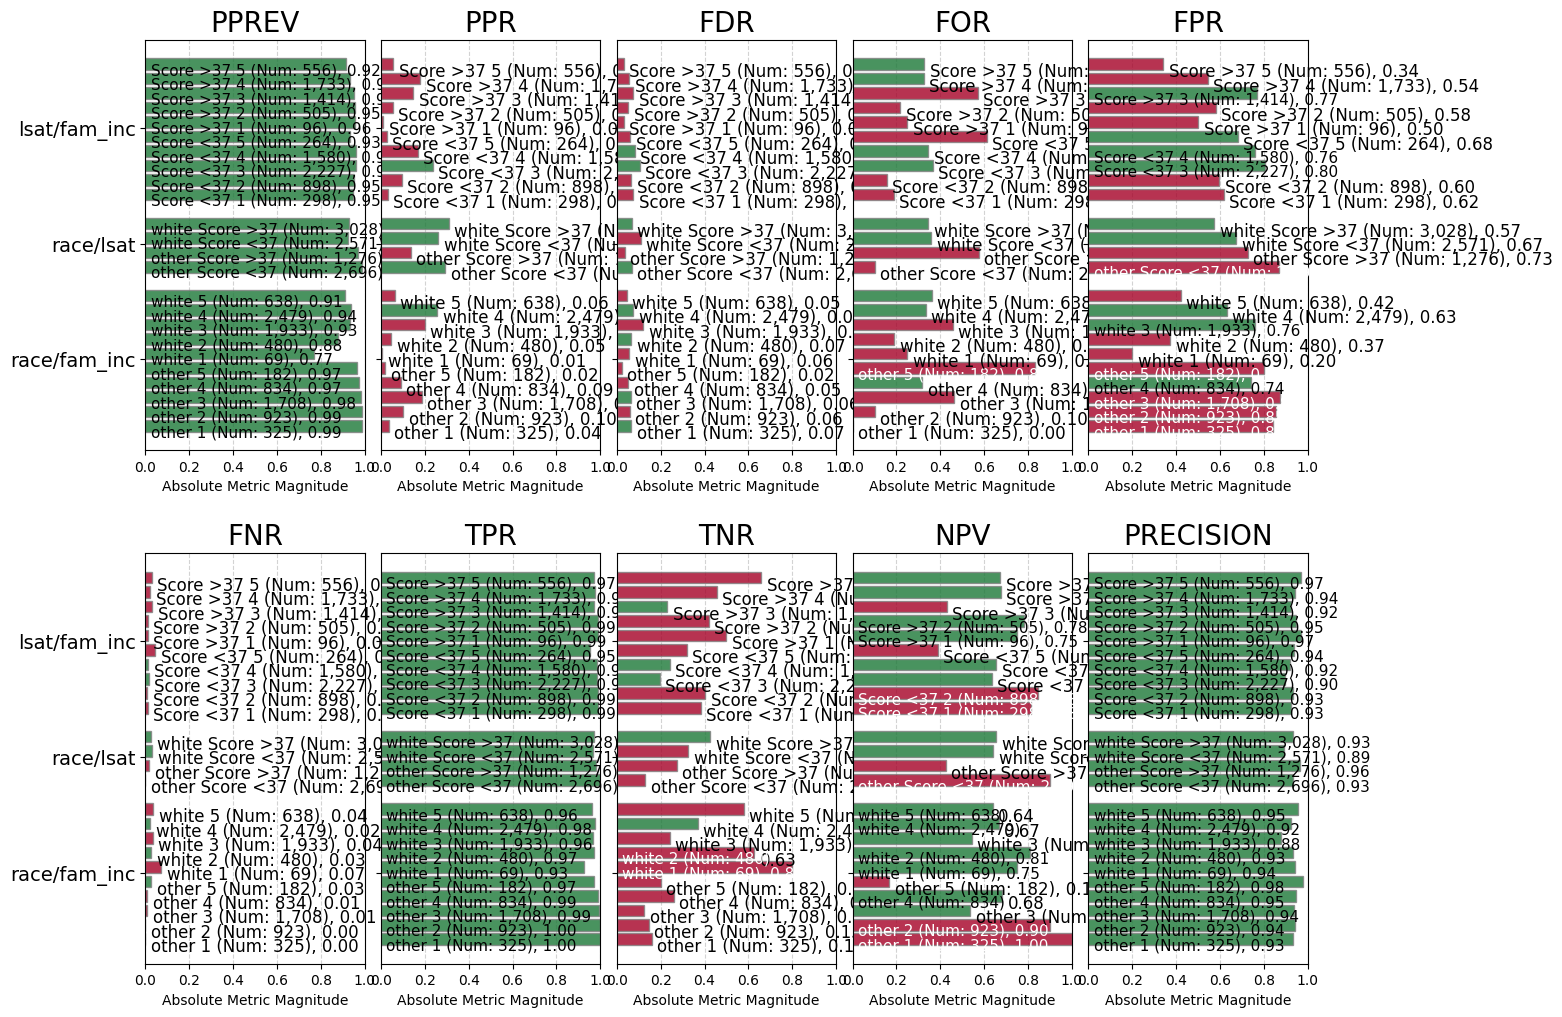

<Figure size 640x480 with 0 Axes>

In [46]:
''' 
2: Prevalance Sampling: Generates a training sample with controllable balanced prevalence for the groups in dataset, either by undersampling or oversampling.
'''
#transform data
data_to_transform = df_intersect.copy()
data_transformed_ps = prep_prev_sampling(data_to_transform, protected_attributes_int, target)
#train the new dataset
x_test_ps, y_test_ps, y_predicted_dict_ps, metrics_ps_dict = split_and_train(data_transformed_ps,protected_attributes_int,target)
df_test_transformed_ps =calc_fairness_report(x_test_ps, y_test_ps, y_predicted_dict_ps["DecisionTree"],target,protected_attributes_int,list_of_disparities, priv,display_disp=True)


['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other Score <37': 0, 'other Score >37': 1, 'white Score <37': 2, 'white Score >37': 3}
Attribute: lsat/fam_inc
{'Score <37 1': 0, 'Score <37 2': 1, 'Score <37 3': 2, 'Score <37 4': 3, 'Score <37 5': 4, 'Score >37 1': 5, 'Score >37 2': 6, 'Score >37 3': 7, 'Score >37 4': 8, 'Score >37 5': 9}
[]
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=12, min_samples_leaf=46)
Accuracy score training:
0.8991
Accuracy score test:
0.8885
----------------------------------------



attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.63  0.75  0.36  0.62  0.27  0.64   
1    race/fam_inc               1      0.72  0.85  0.22  0.71  0.19  0.78   
2    race/fam_inc               2      0.75  0.81  0.63  0.41  0.17  0.37   
3    race/fam_inc               3      0.77  0.93  0.30  0.41  0.20  0.70   
4    race/fam_inc               4      0.78  0.82  0.60  0.57  0.10  0.40   
5    race/fam_inc               5      0.85  1.00  0.00   NaN  0.15  1.00   
6    race/fam_inc               6      0.93  0.99  0.11  0.50  0.06  0.89   
7    race/fam_inc               7      0.91  1.00  0.04  0.38  0.09  0.96   
8    race/fam_inc               8      0.92  0.99  0.02  0.80  0.08  0.98   
9    race/fam_inc               9      0.92  1.00  0.00   NaN  0.08  1.00   
10      race/lsat               0      0.68  0.76  0.50  0.48  0.25  0.50   
11      race/lsat               1      0.92  1.00  0.00   NaN  0.08  1.00   
12      race/lsat               2      0.86  0.99  0.04  0.60  0.13  0.96   
13      race/lsat               3      0.95  1.00  0.01  0.50  0.05  0.99   
14   lsat/fam_inc               0      0.68  0.83  0.28  0.62  0.25  0.72   
15   lsat/fam_inc               1      0.76  0.91  0.17  0.70  0.18  0.83   
16   lsat/fam_inc               2      0.82  0.94  0.35  0.41  0.15  0.65   
17   lsat/fam_inc               3      0.84  0.97  0.13  0.53  0.14  0.87   
18   lsat/fam_inc               4      0.85  0.96  0.17  0.57  0.12  0.83   
19   lsat/fam_inc               5      0.89  1.00  0.00   NaN  0.11  1.00   
20   lsat/fam_inc               6      0.98  0.99  0.33  0.50  0.01  0.67   
21   lsat/fam_inc               7      0.95  1.00  0.00   NaN  0.05  1.00   
22   lsat/fam_inc               8      0.95  1.00  0.00   NaN  0.05  1.00   
23   lsat/fam_inc               9      0.95  1.00  0.00   NaN  0.05  1.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.25  0.38       0.73  0.01   0.72  0.70  
1   0.15  0.29       0.81  0.03   0.84  0.79  
2   0.19  0.59       0.83  0.04   0.67  0.69  
3   0.07  0.59       0.80  0.04   0.88  0.75  
4   0.18  0.43       0.90  0.01   0.74  0.81  
5   0.00   NaN       0.85  0.01   1.00  0.85  
6   0.01  0.50       0.94  0.07   0.98  0.93  
7   0.00  0.62       0.91  0.31   0.99  0.90  
8   0.01  0.20       0.92  0.41   0.99  0.92  
9   0.00   NaN       0.92  0.08   1.00  0.92  
10  0.24  0.52       0.75  0.08   0.67  0.66  
11  0.00   NaN       0.92  0.05   1.00  0.92  
12  0.01  0.40       0.87  0.37   0.99  0.87  
13  0.00  0.50       0.95  0.51   1.00  0.95  
14  0.17  0.38       0.75  0.01   0.80  0.73  
15  0.09  0.30       0.82  0.05   0.89  0.80  
16  0.06  0.59       0.85  0.17   0.88  0.79  
17  0.03  0.47       0.86  0.18   0.96  0.85  
18  0.04  0.43       0.88  0.03   0.95  0.86  
19  0.00   NaN       0.89  0.01   1.00  0.89  
20  0.01  0.50       0.99  0.04   0.99  0.98  
21  0.00   NaN       0.95  0.18   1.00  0.95  
22  0.00   NaN       0.95  0.27   1.00  0.95  
23  0.00   NaN       0.95  0.05   1.00  0.95

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 3
Majority class for:  lsat/fam_inc  is: 8
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           3.58          47.59   
1    race/fam_inc               1           2.53          27.72   
2    race/fam_inc               2           2.20          37.05   
3    race/fam_inc               3           2.64          12.98   
4    race/fam_inc               4           1.31          34.61   
5    race/fam_inc               5           1.95           0.00   
6    race/fam_inc               6           0.80           1.54   
7    race/fam_inc               7           1.22           0.51   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.01           0.00   
10      race/lsat               0           5.25         456.55   
11      race/lsat               1           1.71           0.00   
12      race/lsat               2           2.71          18.06   
13      race/lsat               3           1.00           1.00   
14   lsat/fam_inc               0           4.65          10.00   
15   lsat/fam_inc               1           3.46          10.00   
16   lsat/fam_inc               2           2.87          10.00   
17   lsat/fam_inc               3           2.63          10.00   
18   lsat/fam_inc               4           2.35          10.00   
19   lsat/fam_inc               5           2.11            NaN   
20   lsat/fam_inc               6           0.21          10.00   
21   lsat/fam_inc               7           1.03            NaN   
22   lsat/fam_inc               8           1.00            NaN   
23   lsat/fam_inc               9           0.98            NaN   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.77           0.65           1.92           0.02   
1            0.89           0.79           1.43           0.07   
2            0.51           0.37           2.95           0.11   
3            0.51           0.72           2.95           0.09   
4            0.71           0.41           2.14           0.01   
5             NaN           1.02            NaN           0.03   
6            0.62           0.90           2.50           0.16   
7            0.47           0.97           3.12           0.75   
8            1.00           1.00           1.00           1.00   
9             NaN           1.02            NaN           0.19   
10           0.95           0.50           1.05           0.15   
11            NaN           1.01            NaN           0.09   
12           1.20           0.97           0.80           0.72   
13           1.00           1.00           1.00           1.00   
14            NaN           0.72            NaN           0.05   
15            NaN           0.83            NaN           0.18   
16            NaN           0.65            NaN           0.64   
17            NaN           0.87            NaN           0.66   
18            NaN           0.83            NaN           0.11   
19            NaN           1.00            NaN           0.02   
20            NaN           0.67            NaN           0.17   
21            NaN           1.00            NaN           0.66   
22            NaN           1.00            NaN           1.00   
23            NaN           1.00            NaN           0.20   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.72                 0.79          22.68           0.75  
1              0.84                 0.87          14.11           0.86  
2              0.67                 0.90          40.27           0.81  
3              0.88                 0.86          18.76           0.94  
4              0.75                 0.97          38.10           0.82  
5              1.01                 0.92           0.00           1.01  
6              0.99                 1.02           7.06           1.00  
7              1.00                 0.98           2.67           1.00  
8              1.00

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc        16.3000          0.785          0.243        14.4650
race/lsat          118.9025          0.870          0.490        13.5725
lsat/fam_inc        10.0000          0.857          0.369        10.0000
Overall average for fnr_disparity:  48.401
Overall average for fpr_disparity:  0.837
Overall average for ppr_disparity:  0.367
Overall average for tnr_disparity:  12.679


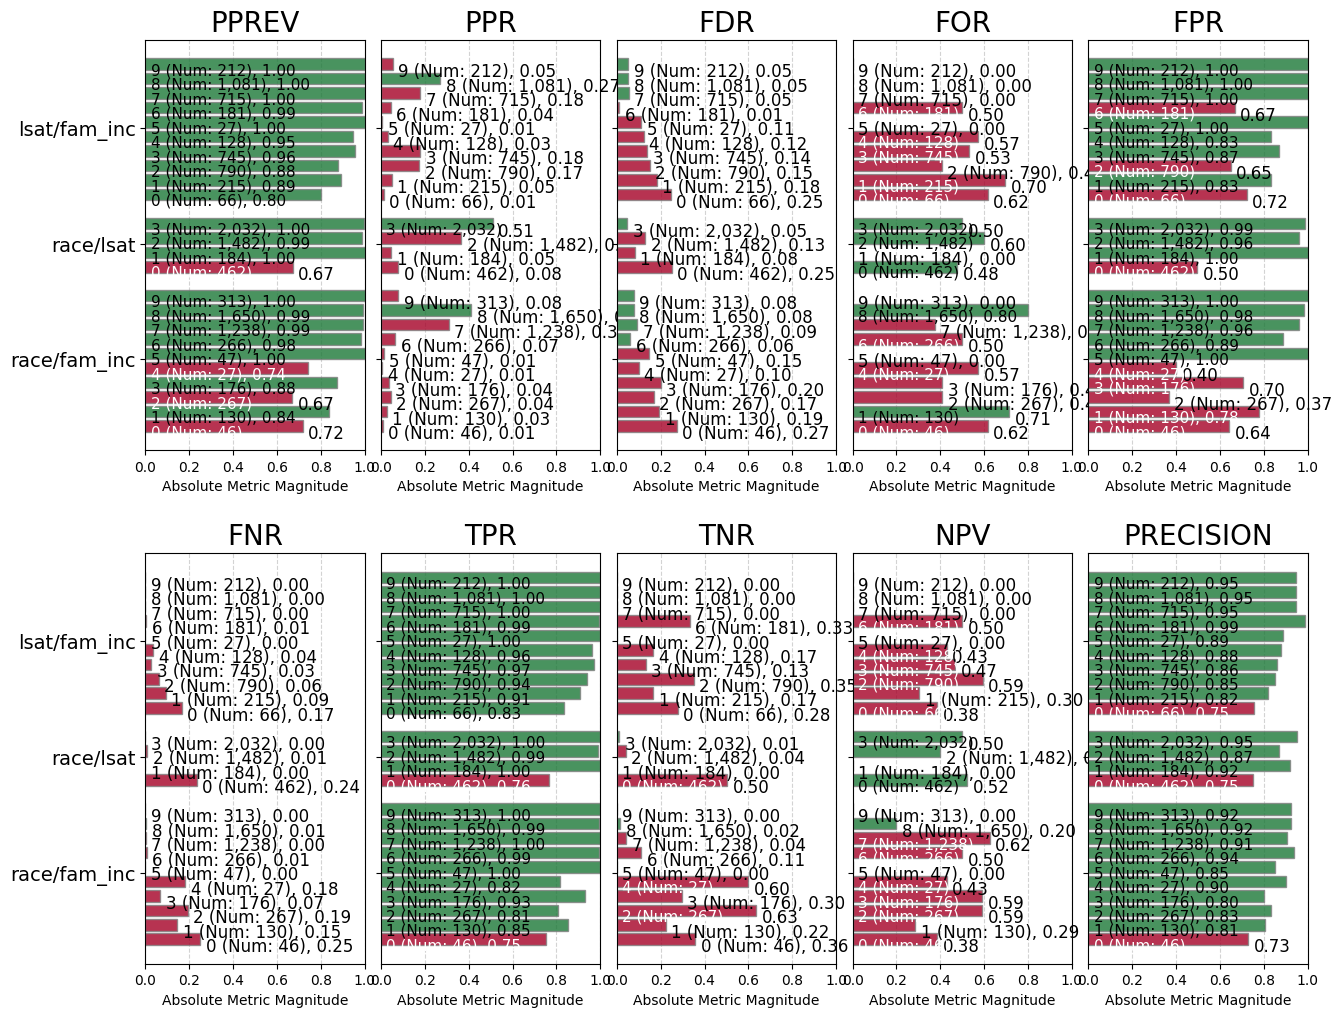

<Figure size 640x480 with 0 Axes>

In [47]:
'''
3. Data repairer: Transforms the data distribution so that a given feature distribution is marginally independent of the sensitive attribute, s. 
'''
df_intersect["ugpagt3"] = df_intersect["ugpagt3"].astype(int)
## data needs to be int
df_int_num = encode_categorical_attributes_all(df_intersect, get_categorical_attributes(df_intersect))
data_to_transform = prep_data_repairer(df_int_num, protected_attributes_int, target)
#train
x_test_dr, y_test_dr, y_predicted_dict_dr, metrics_dr_dict = split_and_train(data_to_transform,protected_attributes_int,target)
#calc metrics
df_test_transformed_dr =calc_fairness_report(x_test_dr, y_test_dr, y_predicted_dict_dr["DecisionTree"],target,protected_attributes_int,list_of_disparities, priv,display_disp=True)

[INFO] 2024-12-07 20:35:04 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-12-07 20:35:04 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Flipped 635 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 635 instances.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Flipped 569 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 569 instances.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Instantiating a LabelFlipping preprocessing method.


INFO:methods.preprocessing.LabelFlipping:Instantiating a LabelFlipping preprocessing method.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Fitting LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Fitting LabelFlipping.


[INFO] 2024-12-07 20:35:05 methods.preprocessing.LabelFlipping - Transforming data with LabelFlipping.


INFO:methods.preprocessing.LabelFlipping:Transforming data with LabelFlipping.


[INFO] 2024-12-07 20:35:06 methods.preprocessing.LabelFlipping - Flipped 743 instances.


INFO:methods.preprocessing.LabelFlipping:Flipped 743 instances.


[INFO] 2024-12-07 20:35:06 methods.preprocessing.LabelFlipping - Data transformed.


INFO:methods.preprocessing.LabelFlipping:Data transformed.


['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other Score <37': 0, 'other Score >37': 1, 'white Score <37': 2, 'white Score >37': 3}
Attribute: lsat/fam_inc
{'Score <37 1': 0, 'Score <37 2': 1, 'Score <37 3': 2, 'Score <37 4': 3, 'Score <37 5': 4, 'Score >37 1': 5, 'Score >37 2': 6, 'Score >37 3': 7, 'Score >37 4': 8, 'Score >37 5': 9}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=10)
Accuracy score training:
0.9894
Accuracy score test:
0.9825
----------------------------------------



attribute_name  attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc          other 1      0.98  0.98   NaN  1.00  0.00   NaN   
1    race/fam_inc          other 2      0.99  0.99   NaN  1.00  0.00   NaN   
2    race/fam_inc          other 3      0.90  0.93  0.65  0.44  0.05  0.35   
3    race/fam_inc          other 4      0.97  0.99  0.20  0.50  0.02  0.80   
4    race/fam_inc          other 5      0.93  0.96  0.00  1.00  0.04  1.00   
5    race/fam_inc          white 1      1.00  1.00   NaN   NaN  0.00   NaN   
6    race/fam_inc          white 2      1.00  1.00   NaN   NaN  0.00   NaN   
7    race/fam_inc          white 3      0.98  0.99  0.42  0.35  0.02  0.58   
8    race/fam_inc          white 4      1.00  1.00  0.44  0.43  0.00  0.56   
9    race/fam_inc          white 5      1.00  1.00  1.00  0.00  0.00  0.00   
10      race/lsat  other Score <37      0.93  0.96  0.57  0.47  0.04  0.43   
11      race/lsat  other Score >37      0.98  0.99  0.50  0.67  0.01  0.50   
12      race/lsat  white Score <37      0.98  0.99  0.41  0.38  0.02  0.59   
13      race/lsat  white Score >37      1.00  1.00  0.56  0.29  0.00  0.44   
14   lsat/fam_inc      Score <37 1      0.98  0.98   NaN  1.00  0.00   NaN   
15   lsat/fam_inc      Score <37 2      1.00  1.00   NaN  1.00  0.00   NaN   
16   lsat/fam_inc      Score <37 3      0.93  0.97  0.52  0.42  0.04  0.48   
17   lsat/fam_inc      Score <37 4      0.99  1.00  0.25  0.33  0.01  0.75   
18   lsat/fam_inc      Score <37 5      0.99  1.00  0.00   NaN  0.01  1.00   
19   lsat/fam_inc      Score >37 1      1.00  1.00   NaN   NaN  0.00   NaN   
20   lsat/fam_inc      Score >37 2      1.00  1.00   NaN   NaN  0.00   NaN   
21   lsat/fam_inc      Score >37 3      1.00  1.00  0.50  0.00  0.00  0.50   
22   lsat/fam_inc      Score >37 4      0.99  1.00  0.50  0.50  0.00  0.50   
23   lsat/fam_inc      Score >37 5      1.00  1.00  1.00  0.50  0.00  0.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.02  0.00       1.00  0.01   0.98  1.00  
1   0.01  0.00       1.00  0.03   0.99  1.00  
2   0.07  0.56       0.95  0.06   0.87  0.88  
3   0.01  0.50       0.98  0.04   0.99  0.97  
4   0.04  0.00       0.96  0.01   0.96  0.96  
5   0.00   NaN       1.00  0.01   1.00  1.00  
6   0.00   NaN       1.00  0.07   1.00  1.00  
7   0.01  0.65       0.98  0.30   0.98  0.97  
8   0.00  0.57       1.00  0.40   1.00  0.99  
9   0.00  1.00       1.00  0.08   1.00  1.00  
10  0.04  0.53       0.96  0.10   0.92  0.92  
11  0.01  0.33       0.99  0.04   0.98  0.99  
12  0.01  0.62       0.98  0.36   0.98  0.98  
13  0.00  0.71       1.00  0.50   1.00  1.00  
14  0.02  0.00       1.00  0.02   0.98  1.00  
15  0.00  0.00       1.00  0.05   1.00  1.00  
16  0.03  0.58       0.96  0.18   0.93  0.92  
17  0.00  0.67       0.99  0.18   1.00  0.99  
18  0.00   NaN       0.99  0.03   1.00  0.99  
19  0.00   NaN       1.00  0.01   1.00  1.00  
20  0.00   NaN       1.00  0.04   1.00  1.00  
21  0.00  1.00       1.00  0.17   1.00  0.99  
22  0.00  0.50       1.00  0.26   0.99  0.99  
23  0.00  0.50       1.00  0.05   0.99  1.00

Majority class for:  race/fam_inc  is: white 4
Majority class for:  race/lsat  is: white Score >37
Majority class for:  lsat/fam_inc  is: Score >37 4
[]


attribute_name  attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc          other 1           0.00          11.89   
1    race/fam_inc          other 2           0.00           4.21   
2    race/fam_inc          other 3          15.65          37.08   
3    race/fam_inc          other 4           7.55           3.20   
4    race/fam_inc          other 5          12.64          21.04   
5    race/fam_inc          white 1           0.00           0.00   
6    race/fam_inc          white 2           0.00           0.00   
7    race/fam_inc          white 3           5.68           3.64   
8    race/fam_inc          white 4           1.00           1.00   
9    race/fam_inc          white 5           0.00           0.00   
10      race/lsat  other Score <37          17.91          42.64   
11      race/lsat  other Score >37           2.80          11.12   
12      race/lsat  white Score <37           7.64           6.30   
13      race/lsat  white Score >37           1.00           1.00   
14   lsat/fam_inc      Score <37 1           0.00           5.43   
15   lsat/fam_inc      Score <37 2           0.00           1.67   
16   lsat/fam_inc      Score <37 3          14.67          11.83   
17   lsat/fam_inc      Score <37 4           2.90           0.49   
18   lsat/fam_inc      Score <37 5           2.80           0.00   
19   lsat/fam_inc      Score >37 1           0.00           0.00   
20   lsat/fam_inc      Score >37 2           0.00           0.00   
21   lsat/fam_inc      Score >37 3           1.01           0.00   
22   lsat/fam_inc      Score >37 4           1.00           1.00   
23   lsat/fam_inc      Score >37 5           0.00           1.70   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            2.33            NaN           0.00           0.03   
1            2.33            NaN           0.00           0.08   
2            1.04           0.64           0.97           0.14   
3            1.17           1.44           0.88           0.11   
4            2.33           1.80           0.00           0.02   
5             NaN            NaN            NaN           0.03   
6             NaN            NaN            NaN           0.16   
7            0.81           1.05           1.14           0.74   
8            1.00           1.00           1.00           1.00   
9            0.00           0.00           1.75           0.19   
10           1.66           0.96           0.74           0.21   
11           2.33           1.12           0.47           0.09   
12           1.31           1.34           0.88           0.72   
13           1.00           1.00           1.00           1.00   
14           2.00            NaN           0.00           0.06   
15           2.00            NaN           0.00           0.20   
16           0.84           0.95           1.16           0.68   
17           0.67           1.50           1.33           0.69   
18            NaN           2.00            NaN           0.12   
19            NaN            NaN            NaN           0.03   
20            NaN            NaN            NaN           0.17   
21           0.00           1.00           2.00           0.66   
22           1.00           1.00           1.00           1.00   
23           1.00           0.00           1.00           0.20   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.98                 1.00            NaN           0.98  
1              1.00                 1.00            NaN           0.99  
2              0.87                 0.96           1.45           0.93  
3              0.99                 0.98           0.45           1.00  
4              0.97                 0.96           0.00           0.96  
5              1.00                 1.00            NaN           1.00  
6              1.00                 1.00            NaN           1.00  
7              0.99                 0.99           0.94           1

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc       9.006667          0.986       0.166667       1.018000
race/lsat         20.020000          1.140       0.340000       0.886667
lsat/fam_inc       2.346667          1.090       0.312222       0.910000
Overall average for fnr_disparity:  10.458
Overall average for fpr_disparity:  1.072
Overall average for ppr_disparity:  0.273
Overall average for tnr_disparity:  0.938


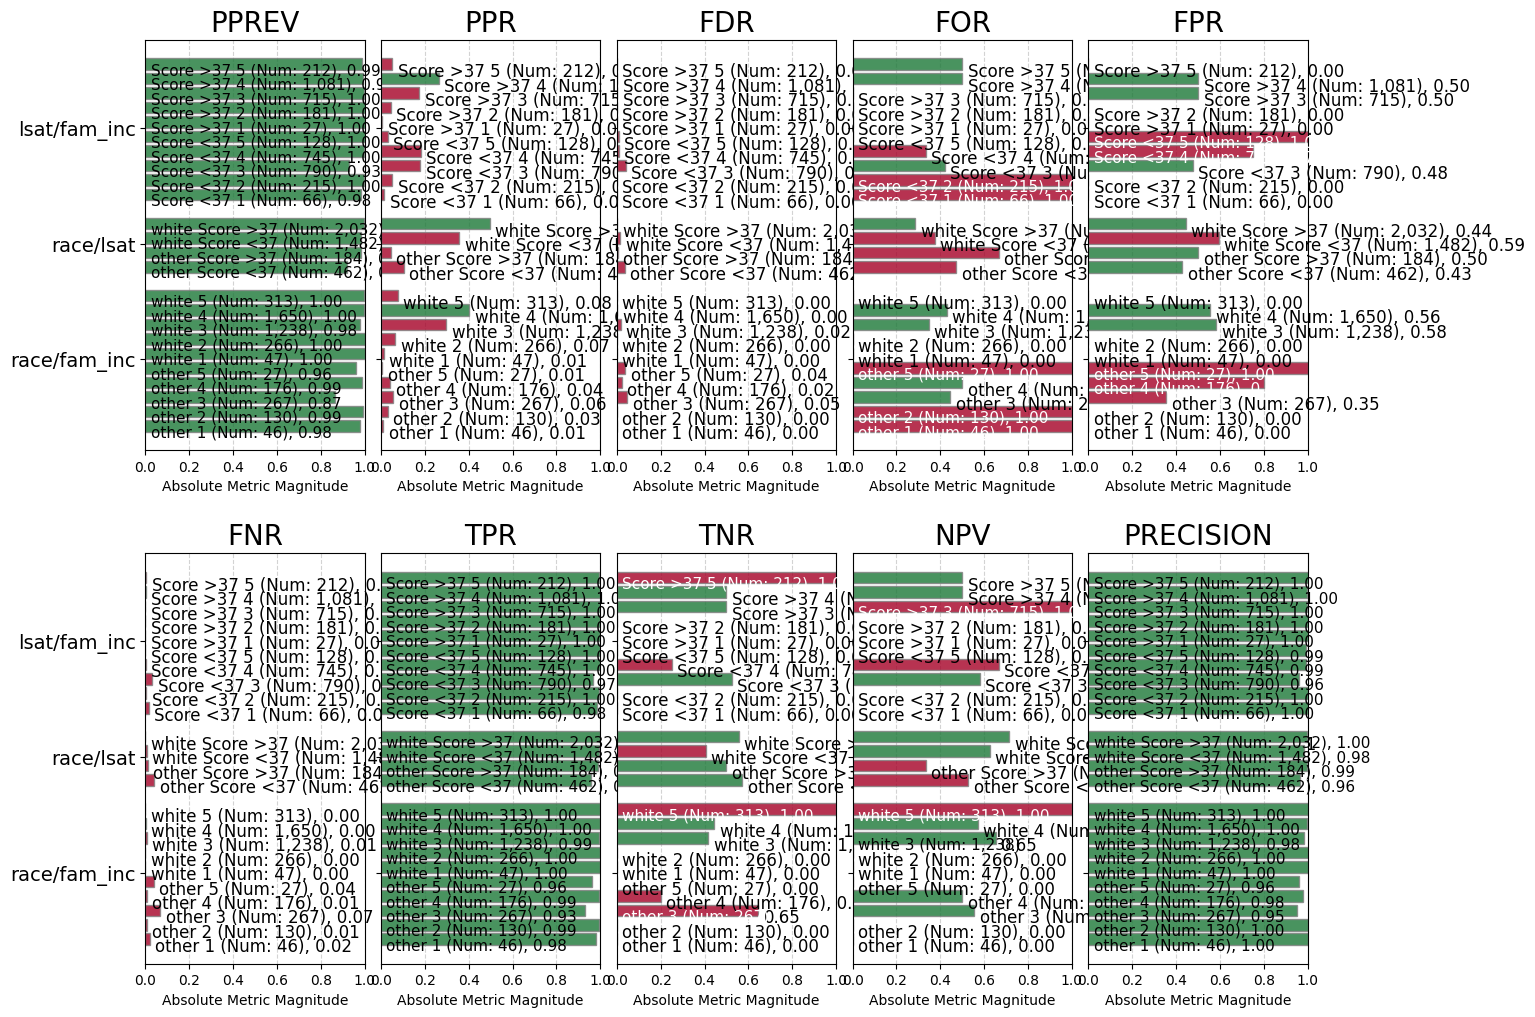

174419

<Figure size 640x480 with 0 Axes>

In [48]:
'''
4. Label flipping
'''
#transform data
data_to_transform = prep_label_flipping(df_intersect, protected_attributes_int, target)
#train
x_test_lf, y_test_lf, y_predicted_dict_lf, metrics_lf_dict = split_and_train(data_to_transform,
                                                                             protected_attributes_int,target)
#calc metrics
df_test_transformed_lf = calc_fairness_report(x_test_lf, y_test_lf, y_predicted_dict_lf["DecisionTree"], target,
                                              protected_attributes_int, list_of_disparities, priv, display_disp=True)
gc.collect()

In [50]:
'''
In-processing: Fair learn classifier 
'''
data_to_transform = df_intersect.copy()
data_to_transform = encode_categorical_attributes_all(data_to_transform, get_categorical_attributes(data_to_transform))
models = ["sklearn.tree.DecisionTreeClassifier"]
metrics_dict = {}
for attr in protected_attributes_int:
    x_test_fl, y_test_fl, y_test_pred_fl, metrics_dict_fl =train_with_fairlearn(data_to_transform,attr, models[0], metrics_dict,target)
    #calc metrics
    df_test_transformed_fl =calc_fairness_report(x_test_fl, y_test_fl, y_test_pred_fl,target,protected_attributes_int, list_of_disparities, priv,display_disp=True)

['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other Score <37': 0, 'other Score >37': 1, 'white Score <37': 2, 'white Score >37': 3}
Attribute: lsat/fam_inc
{'Score <37 1': 0, 'Score <37 2': 1, 'Score <37 3': 2, 'Score <37 4': 3, 'Score <37 5': 4, 'Score >37 1': 5, 'Score >37 2': 6, 'Score >37 3': 7, 'Score >37 4': 8, 'Score >37 5': 9}
[INFO] 2024-12-07 20:37:32 methods.inprocessing.ExponentiatedGradient - Instantiating estimator '<class 'sklearn.tree._classes.DecisionTreeClassifier'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating estimator '<class 'sklearn.tree._classes.DecisionTreeClassifier'>' with parameters: {}.


[INFO] 2024-12-07 20:37:32 methods.inprocessing.ExponentiatedGradient - Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating constraint '<class 'fairlearn.reductions._moments.utility_parity.EqualizedOdds'>' with parameters: {}.


[INFO] 2024-12-07 20:37:32 methods.inprocessing.ExponentiatedGradient - Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


INFO:methods.inprocessing.ExponentiatedGradient:Instantiating reduction '<class 'fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient'>' with parameters: {}.


Model:
 sklearn.tree.DecisionTreeClassifier
Accuracy score training:
0.1097
Accuracy score test:
0.1123
Classification report for model: sklearn.tree.DecisionTreeClassifier : 
               precision    recall  f1-score   support

           0       0.11      1.00      0.20       467
           1       0.00      0.00      0.00      3693

    accuracy                           0.11      4160
   macro avg       0.06      0.50      0.10      4160
weighted avg       0.01      0.11      0.02      4160



attribute_name attribute_value  accuracy  tpr  tnr   for  fdr  fpr  fnr  \
0    race/fam_inc               0      0.30  0.0  1.0  0.70  NaN  0.0  1.0   
1    race/fam_inc               1      0.21  0.0  1.0  0.79  NaN  0.0  1.0   
2    race/fam_inc               2      0.31  0.0  1.0  0.69  NaN  0.0  1.0   
3    race/fam_inc               3      0.25  0.0  1.0  0.75  NaN  0.0  1.0   
4    race/fam_inc               4      0.19  0.0  1.0  0.81  NaN  0.0  1.0   
5    race/fam_inc               5      0.15  0.0  1.0  0.85  NaN  0.0  1.0   
6    race/fam_inc               6      0.07  0.0  1.0  0.93  NaN  0.0  1.0   
7    race/fam_inc               7      0.10  0.0  1.0  0.90  NaN  0.0  1.0   
8    race/fam_inc               8      0.08  0.0  1.0  0.92  NaN  0.0  1.0   
9    race/fam_inc               9      0.08  0.0  1.0  0.92  NaN  0.0  1.0   
10      race/lsat               0      0.34  0.0  1.0  0.66  NaN  0.0  1.0   
11      race/lsat               1      0.08  0.0  1.0  0.92  NaN  0.0  1.0   
12      race/lsat               2      0.13  0.0  1.0  0.87  NaN  0.0  1.0   
13      race/lsat               3      0.05  0.0  1.0  0.95  NaN  0.0  1.0   
14   lsat/fam_inc               0      0.27  0.0  1.0  0.73  NaN  0.0  1.0   
15   lsat/fam_inc               1      0.20  0.0  1.0  0.80  NaN  0.0  1.0   
16   lsat/fam_inc               2      0.21  0.0  1.0  0.79  NaN  0.0  1.0   
17   lsat/fam_inc               3      0.15  0.0  1.0  0.85  NaN  0.0  1.0   
18   lsat/fam_inc               4      0.14  0.0  1.0  0.86  NaN  0.0  1.0   
19   lsat/fam_inc               5      0.11  0.0  1.0  0.89  NaN  0.0  1.0   
20   lsat/fam_inc               6      0.02  0.0  1.0  0.98  NaN  0.0  1.0   
21   lsat/fam_inc               7      0.05  0.0  1.0  0.95  NaN  0.0  1.0   
22   lsat/fam_inc               8      0.05  0.0  1.0  0.95  NaN  0.0  1.0   
23   lsat/fam_inc               9      0.05  0.0  1.0  0.95  NaN  0.0  1.0   

     npv  precision  ppr  pprev  prev  
0   0.30        NaN  NaN    0.0  0.70  
1   0.21        NaN  NaN    0.0  0.79  
2   0.31        NaN  NaN    0.0  0.69  
3   0.25        NaN  NaN    0.0  0.75  
4   0.19        NaN  NaN    0.0  0.81  
5   0.15        NaN  NaN    0.0  0.85  
6   0.07        NaN  NaN    0.0  0.93  
7   0.10        NaN  NaN    0.0  0.90  
8   0.08        NaN  NaN    0.0  0.92  
9   0.08        NaN  NaN    0.0  0.92  
10  0.34        NaN  NaN    0.0  0.66  
11  0.08        NaN  NaN    0.0  0.92  
12  0.13        NaN  NaN    0.0  0.87  
13  0.05        NaN  NaN    0.0  0.95  
14  0.27        NaN  NaN    0.0  0.73  
15  0.20        NaN  NaN    0.0  0.80  
16  0.21        NaN  NaN    0.0  0.79  
17  0.15        NaN  NaN    0.0  0.85  
18  0.14        NaN  NaN    0.0  0.86  
19  0.11        NaN  NaN    0.0  0.89  
20  0.02        NaN  NaN    0.0  0.98  
21  0.05        NaN  NaN    0.0  0.95  
22  0.05        NaN  NaN    0.0  0.95  
23  0.05        NaN  NaN    0.0  0.95

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 3
Majority class for:  lsat/fam_inc  is: 8


AttributeError: 'bool' object has no attribute 'astype'

In [51]:
"""Gerry fair"""""
data_to_transform = encode_categorical_attributes_all(df_intersect,get_categorical_attributes(df_intersect))

maj_1 = get_majority_classes(data_to_transform["race/fam_inc"])[0]
maj_2 = get_majority_classes(data_to_transform["race/lsat"])[0]
maj_3 = get_majority_classes(data_to_transform["lsat/fam_inc"])[0]
maj_classes = [[maj_1],[maj_2],[maj_3]]
x_test_gf,y_test_gf,y_test_pred_gf = in_process_gerryfair(data_to_transform,target, protected_attributes_int, maj_classes, len(df_intersect)-len(x_test_int))
df_test_transformed_gf =calc_fairness_report(x_test_gf, y_test_gf, y_test_pred_gf,target,protected_attributes_int, list_of_disparities, priv,display_disp=True)

['age', 'gender', 'cluster', 'fulltime', 'race/fam_inc', 'race/lsat', 'lsat/fam_inc']
Attribute: age
{'0': 0, '1': 1}
Attribute: gender
{'female': 0, 'male': 1}
Attribute: cluster
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
Attribute: fulltime
{'1': 0, '2': 1}
Attribute: race/fam_inc
{'other 1': 0, 'other 2': 1, 'other 3': 2, 'other 4': 3, 'other 5': 4, 'white 1': 5, 'white 2': 6, 'white 3': 7, 'white 4': 8, 'white 5': 9}
Attribute: race/lsat
{'other Score <37': 0, 'other Score >37': 1, 'white Score <37': 2, 'white Score >37': 3}
Attribute: lsat/fam_inc
{'Score <37 1': 0, 'Score <37 2': 1, 'Score <37 3': 2, 'Score <37 4': 3, 'Score <37 5': 4, 'Score >37 1': 5, 'Score >37 2': 6, 'Score >37 3': 7, 'Score >37 4': 8, 'Score >37 5': 9}
Accuracy score test:
0.8868


attribute_name attribute_value  accuracy  tpr  tnr  for   fdr  fpr  fnr  \
0    race/fam_inc             0.0      0.56  1.0  0.0  NaN  0.44  1.0  0.0   
1    race/fam_inc             1.0      0.71  1.0  0.0  NaN  0.29  1.0  0.0   
2    race/fam_inc             2.0      0.68  1.0  0.0  NaN  0.32  1.0  0.0   
3    race/fam_inc             3.0      0.80  1.0  0.0  NaN  0.20  1.0  0.0   
4    race/fam_inc             4.0      0.78  1.0  0.0  NaN  0.22  1.0  0.0   
5    race/fam_inc             5.0      0.90  1.0  0.0  NaN  0.10  1.0  0.0   
6    race/fam_inc             6.0      0.93  1.0  0.0  NaN  0.07  1.0  0.0   
7    race/fam_inc             7.0      0.91  1.0  0.0  NaN  0.09  1.0  0.0   
8    race/fam_inc             8.0      0.93  1.0  0.0  NaN  0.07  1.0  0.0   
9    race/fam_inc             9.0      0.93  1.0  0.0  NaN  0.07  1.0  0.0   
10      race/lsat             0.0      0.64  1.0  0.0  NaN  0.36  1.0  0.0   
11      race/lsat             1.0      0.90  1.0  0.0  NaN  0.10  1.0  0.0   
12      race/lsat             2.0      0.88  1.0  0.0  NaN  0.12  1.0  0.0   
13      race/lsat             3.0      0.96  1.0  0.0  NaN  0.04  1.0  0.0   
14   lsat/fam_inc             0.0      0.59  1.0  0.0  NaN  0.41  1.0  0.0   
15   lsat/fam_inc             1.0      0.78  1.0  0.0  NaN  0.22  1.0  0.0   
16   lsat/fam_inc             2.0      0.78  1.0  0.0  NaN  0.22  1.0  0.0   
17   lsat/fam_inc             3.0      0.87  1.0  0.0  NaN  0.13  1.0  0.0   
18   lsat/fam_inc             4.0      0.84  1.0  0.0  NaN  0.16  1.0  0.0   
19   lsat/fam_inc             5.0      0.89  1.0  0.0  NaN  0.11  1.0  0.0   
20   lsat/fam_inc             6.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   
21   lsat/fam_inc             7.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   
22   lsat/fam_inc             8.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   
23   lsat/fam_inc             9.0      0.95  1.0  0.0  NaN  0.05  1.0  0.0   

    npv  precision   ppr  pprev  prev  
0   NaN       0.56  0.01    1.0  0.56  
1   NaN       0.71  0.03    1.0  0.71  
2   NaN       0.68  0.07    1.0  0.68  
3   NaN       0.80  0.05    1.0  0.80  
4   NaN       0.78  0.01    1.0  0.78  
5   NaN       0.90  0.01    1.0  0.90  
6   NaN       0.93  0.07    1.0  0.93  
7   NaN       0.91  0.30    1.0  0.91  
8   NaN       0.93  0.38    1.0  0.93  
9   NaN       0.93  0.08    1.0  0.93  
10  NaN       0.64  0.12    1.0  0.64  
11  NaN       0.90  0.05    1.0  0.90  
12  NaN       0.88  0.35    1.0  0.88  
13  NaN       0.96  0.48    1.0  0.96  
14  NaN       0.59  0.01    1.0  0.59  
15  NaN       0.78  0.05    1.0  0.78  
16  NaN       0.78  0.20    1.0  0.78  
17  NaN       0.87  0.18    1.0  0.87  
18  NaN       0.84  0.03    1.0  0.84  
19  NaN       0.89  0.01    1.0  0.89  
20  NaN       0.95  0.05    1.0  0.95  
21  NaN       0.95  0.18    1.0  0.95  
22  NaN       0.95  0.25    1.0  0.95  
23  NaN       0.95  0.05    1.0  0.95

Majority class for:  race/fam_inc  is: 8.0
Majority class for:  race/lsat  is: 3.0
Majority class for:  lsat/fam_inc  is: 8.0
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc             0.0           6.27            NaN   
1    race/fam_inc             1.0           4.13            NaN   
2    race/fam_inc             2.0           4.63            NaN   
3    race/fam_inc             3.0           2.90            NaN   
4    race/fam_inc             4.0           3.09            NaN   
5    race/fam_inc             5.0           1.43            NaN   
6    race/fam_inc             6.0           0.97            NaN   
7    race/fam_inc             7.0           1.32            NaN   
8    race/fam_inc             8.0           1.00            NaN   
9    race/fam_inc             9.0           1.05            NaN   
10      race/lsat             0.0           8.22            NaN   
11      race/lsat             1.0           2.20            NaN   
12      race/lsat             2.0           2.81            NaN   
13      race/lsat             3.0           1.00            NaN   
14   lsat/fam_inc             0.0           7.97            NaN   
15   lsat/fam_inc             1.0           4.20            NaN   
16   lsat/fam_inc             2.0           4.20            NaN   
17   lsat/fam_inc             3.0           2.58            NaN   
18   lsat/fam_inc             4.0           3.09            NaN   
19   lsat/fam_inc             5.0           2.16            NaN   
20   lsat/fam_inc             6.0           0.92            NaN   
21   lsat/fam_inc             7.0           0.88            NaN   
22   lsat/fam_inc             8.0           1.00            NaN   
23   lsat/fam_inc             9.0           0.96            NaN   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0             NaN            1.0            NaN           0.03   
1             NaN            1.0            NaN           0.08   
2             NaN            1.0            NaN           0.19   
3             NaN            1.0            NaN           0.13   
4             NaN            1.0            NaN           0.02   
5             NaN            1.0            NaN           0.02   
6             NaN            1.0            NaN           0.18   
7             NaN            1.0            NaN           0.80   
8             NaN            1.0            NaN           1.00   
9             NaN            1.0            NaN           0.20   
10            NaN            1.0            NaN           0.25   
11            NaN            1.0            NaN           0.11   
12            NaN            1.0            NaN           0.74   
13            NaN            1.0            NaN           1.00   
14            NaN            1.0            NaN           0.04   
15            NaN            1.0            NaN           0.21   
16            NaN            1.0            NaN           0.80   
17            NaN            1.0            NaN           0.72   
18            NaN            1.0            NaN           0.12   
19            NaN            1.0            NaN           0.03   
20            NaN            1.0            NaN           0.18   
21            NaN            1.0            NaN           0.71   
22            NaN            1.0            NaN           1.00   
23            NaN            1.0            NaN           0.22   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0               1.0                 0.60            NaN            1.0  
1               1.0                 0.76            NaN            1.0  
2               1.0                 0.73            NaN            1.0  
3               1.0                 0.86            NaN            1.0  
4               1.0                 0.84            NaN            1.0  
5               1.0                 0.97            NaN            1.0  
6               1.0                 1.00            NaN            1.0  
7               1.0                 0.98            NaN            1.0  
8               1.0

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc            NaN            1.0          0.265            NaN
race/lsat               NaN            1.0          0.525            NaN
lsat/fam_inc            NaN            1.0          0.403            NaN
Overall average for fnr_disparity:  nan
Overall average for fpr_disparity:  1.000
Overall average for ppr_disparity:  0.398
Overall average for tnr_disparity:  nan


<Figure size 640x480 with 0 Axes>

---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=9, min_samples_leaf=16)
Accuracy score test corrected:
0.7243


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.57  0.66  0.36  0.69  0.30  0.64   
1    race/fam_inc               1      0.61  0.64  0.48  0.74  0.18  0.52   
2    race/fam_inc               2      0.74  0.73  0.76  0.45  0.13  0.24   
3    race/fam_inc               3      0.68  0.71  0.59  0.59  0.16  0.41   
4    race/fam_inc               4      0.67  0.59  1.00  0.64  0.00  0.00   
5    race/fam_inc               5      0.83  0.88  0.57  0.56  0.08  0.43   
6    race/fam_inc               6      0.76  0.75  0.78  0.81  0.02  0.22   
7    race/fam_inc               7      0.75  0.75  0.75  0.76  0.03  0.25   
8    race/fam_inc               8      0.72  0.72  0.65  0.84  0.04  0.35   
9    race/fam_inc               9      0.72  0.73  0.67  0.83  0.04  0.33   
10      race/lsat               0      0.67  0.67  0.66  0.49  0.21  0.34   
11      race/lsat               1      0.72  0.73  0.53  0.85  0.05  0.47   
12      race/lsat               2      0.74  0.74  0.70  0.71  0.06  0.30   
13      race/lsat               3      0.73  0.73  0.69  0.88  0.02  0.31   
14   lsat/fam_inc               0      0.68  0.77  0.44  0.58  0.21  0.56   
15   lsat/fam_inc               1      0.68  0.71  0.57  0.68  0.13  0.43   
16   lsat/fam_inc               2      0.75  0.75  0.75  0.56  0.08  0.25   
17   lsat/fam_inc               3      0.71  0.72  0.64  0.71  0.08  0.36   
18   lsat/fam_inc               4      0.70  0.70  0.72  0.72  0.06  0.28   
19   lsat/fam_inc               5      0.74  0.79  0.33  0.83  0.10  0.67   
20   lsat/fam_inc               6      0.74  0.74  1.00  0.94  0.00  0.00   
21   lsat/fam_inc               7      0.74  0.74  0.74  0.86  0.02  0.26   
22   lsat/fam_inc               8      0.71  0.72  0.61  0.89  0.03  0.39   
23   lsat/fam_inc               9      0.73  0.73  0.73  0.87  0.02  0.27   

     fnr   npv  precision   ppr  pprev  prev  
0   0.34  0.31       0.70  0.01   0.65  0.70  
1   0.36  0.26       0.82  0.03   0.62  0.79  
2   0.27  0.55       0.87  0.05   0.58  0.69  
3   0.29  0.41       0.84  0.04   0.64  0.75  
4   0.41  0.36       1.00  0.00   0.48  0.81  
5   0.12  0.44       0.92  0.01   0.81  0.85  
6   0.25  0.19       0.98  0.07   0.72  0.93  
7   0.25  0.24       0.97  0.30   0.70  0.90  
8   0.28  0.16       0.96  0.40   0.69  0.92  
9   0.27  0.17       0.96  0.08   0.70  0.92  
10  0.33  0.51       0.79  0.09   0.56  0.66  
11  0.27  0.15       0.95  0.05   0.71  0.92  
12  0.26  0.29       0.94  0.36   0.69  0.87  
13  0.27  0.12       0.98  0.51   0.71  0.95  
14  0.23  0.42       0.79  0.02   0.71  0.73  
15  0.29  0.32       0.87  0.05   0.65  0.80  
16  0.25  0.44       0.92  0.18   0.65  0.79  
17  0.28  0.29       0.92  0.17   0.67  0.85  
18  0.30  0.28       0.94  0.03   0.64  0.86  
19  0.21  0.17       0.90  0.01   0.78  0.89  
20  0.26  0.06       1.00  0.05   0.72  0.98  
21  0.26  0.14       0.98  0.18   0.72  0.95  
22  0.28  0.11       0.97  0.27   0.70  0.95  
23  0.27  0.13       0.98  0.05   0.70  0.95

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 3
Majority class for:  lsat/fam_inc  is: 8
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           7.62           1.23   
1    race/fam_inc               1           4.44           1.29   
2    race/fam_inc               2           3.28           0.97   
3    race/fam_inc               3           4.08           1.03   
4    race/fam_inc               4           0.00           1.47   
5    race/fam_inc               5           2.01           0.45   
6    race/fam_inc               6           0.53           0.88   
7    race/fam_inc               7           0.88           0.90   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           0.93           0.98   
10      race/lsat               0          10.01           1.21   
11      race/lsat               1           2.57           0.98   
12      race/lsat               2           2.83           0.94   
13      race/lsat               3           1.00           1.00   
14   lsat/fam_inc               0           7.34           0.82   
15   lsat/fam_inc               1           4.44           1.05   
16   lsat/fam_inc               2           2.70           0.89   
17   lsat/fam_inc               3           2.85           1.00   
18   lsat/fam_inc               4           2.10           1.07   
19   lsat/fam_inc               5           3.29           0.74   
20   lsat/fam_inc               6           0.00           0.94   
21   lsat/fam_inc               7           0.67           0.92   
22   lsat/fam_inc               8           1.00           1.00   
23   lsat/fam_inc               9           0.69           0.98   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            0.82           1.81           1.93           0.03   
1            0.88           1.46           1.61           0.07   
2            0.53           0.69           3.42           0.14   
3            0.71           1.15           2.51           0.10   
4            0.77           0.00           2.21           0.01   
5            0.66           1.21           2.75           0.03   
6            0.97           0.63           1.15           0.17   
7            0.91           0.71           1.49           0.76   
8            1.00           1.00           1.00           1.00   
9            0.99           0.94           1.04           0.19   
10           0.56           1.12           4.41           0.18   
11           0.96           1.52           1.31           0.09   
12           0.80           0.99           2.56           0.71   
13           1.00           1.00           1.00           1.00   
14           0.65           1.44           3.87           0.06   
15           0.76           1.11           2.94           0.18   
16           0.63           0.64           4.02           0.67   
17           0.79           0.93           2.70           0.65   
18           0.80           0.72           2.60           0.11   
19           0.93           1.73           1.53           0.03   
20           1.05           0.00           0.55           0.17   
21           0.96           0.66           1.31           0.67   
22           1.00           1.00           1.00           1.00   
23           0.98           0.71           1.17           0.20   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.94                 0.73           0.55           0.91  
1              0.89                 0.86           0.75           0.89  
2              0.84                 0.91           1.17           1.01  
3              0.92                 0.87           0.92           0.99  
4              0.70                 1.04           1.55           0.82  
5              1.17                 0.96           0.89           1.21  
6              1.04                 1.02           1.20           1.05  
7              1.01                 1.01           1.16           1.04  
8              1.00

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc         1.0200         0.9600          0.250          1.022
race/lsat            1.0325         1.1575          0.495          0.930
lsat/fam_inc         0.9410         0.8940          0.374          1.066
Overall average for fnr_disparity:  0.998
Overall average for fpr_disparity:  1.004
Overall average for ppr_disparity:  0.373
Overall average for tnr_disparity:  1.006


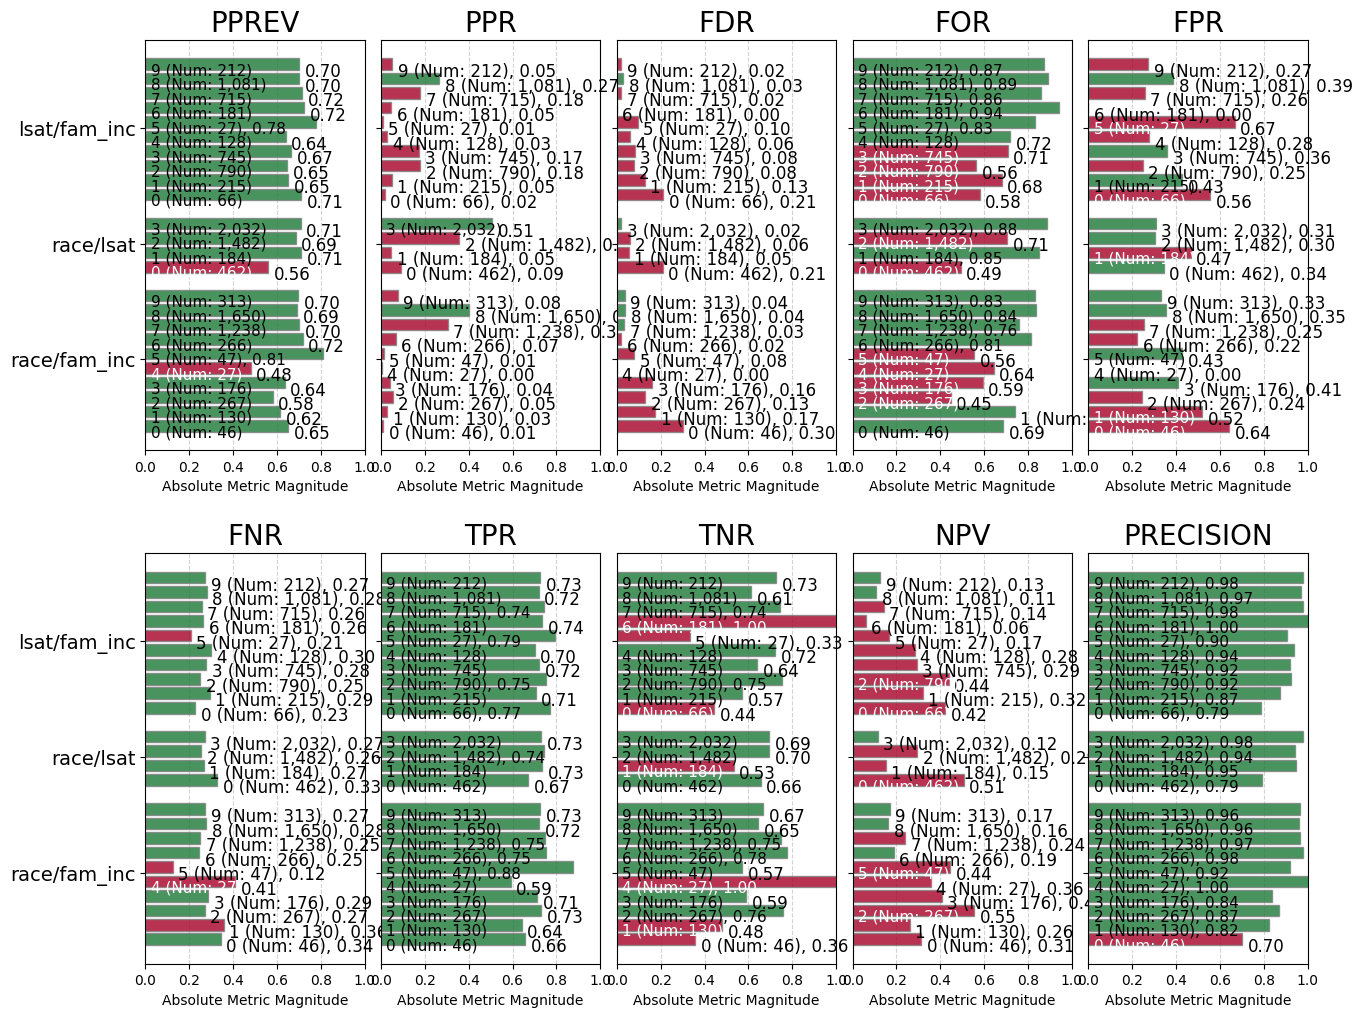

112857

<Figure size 640x480 with 0 Axes>

In [52]:
df_test_fairlearn = post_process_group_threshold_fairlearn(data_to_transform, protected_attributes_int, target,list_of_disparities, priv,"DecisionTree",[])
gc.collect()

{'race/fam_inc': ['white 4'], 'race/lsat': ['white Score >37'], 'lsat/fam_inc': ['Score >37 4']}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=9, min_samples_leaf=16)
[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:18 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.7611


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0      race/lsat               0      0.69  0.76  0.55  0.46  0.23  0.45   
1      race/lsat               1      0.83  0.86  0.40  0.79  0.06  0.60   
2      race/lsat               2      0.82  0.86  0.53  0.63  0.08  0.47   
3      race/lsat               3      0.90  0.92  0.46  0.78  0.03  0.54   

    fnr   npv  precision   ppr  pprev  prev  
0  0.24  0.54       0.77  0.09   0.66  0.66  
1  0.14  0.21       0.94  0.04   0.84  0.92  
2  0.14  0.37       0.92  0.34   0.81  0.87  
3  0.08  0.22       0.97  0.52   0.90  0.95

Majority class for:  race/lsat  is: 3
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0      race/lsat               0           8.08           2.89           0.59   
1      race/lsat               1           2.00           1.65           1.02   
2      race/lsat               2           2.67           1.67           0.81   
3      race/lsat               3           1.00           1.00           1.00   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           0.84           2.46           0.17             0.73   
1           1.11           0.94           0.08             0.94   
2           0.87           1.68           0.66             0.90   
3           1.00           1.00           1.00             1.00   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.79           1.19           0.83  
1                 0.97           0.87           0.94  
2                 0.95           1.15           0.94  
3                 1.00           1.00           1.00

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc            NaN            NaN            NaN            NaN
race/lsat            1.8025          0.955         0.4775         1.0525
lsat/fam_inc            NaN            NaN            NaN            NaN
Overall average for fnr_disparity:  1.802
Overall average for fpr_disparity:  0.955
Overall average for ppr_disparity:  0.478
Overall average for tnr_disparity:  1.052


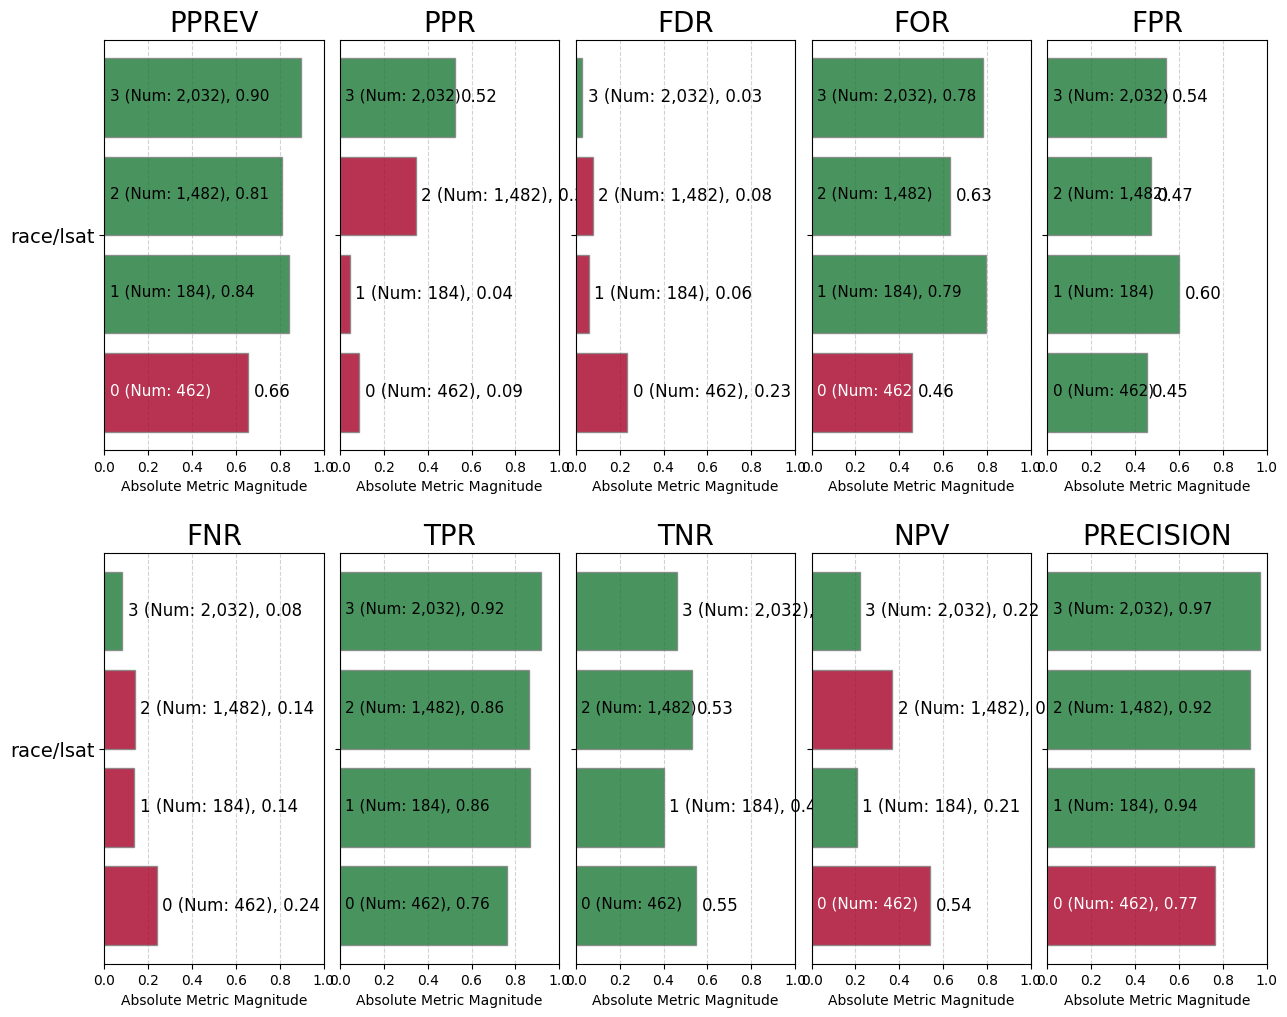

{'race/fam_inc': ['white 4'], 'race/lsat': ['white Score >37'], 'lsat/fam_inc': ['Score >37 4']}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=9, min_samples_leaf=16)
[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:20 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.7748


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0   race/fam_inc               0      0.63  0.72  0.43  0.60  0.26  0.57   
1   race/fam_inc               1      0.70  0.82  0.26  0.73  0.19  0.74   
2   race/fam_inc               2      0.78  0.83  0.66  0.37  0.15  0.34   
3   race/fam_inc               3      0.76  0.87  0.43  0.47  0.18  0.57   
4   race/fam_inc               4      0.74  0.73  0.80  0.60  0.06  0.20   
5   race/fam_inc               5      0.83  0.92  0.29  0.60  0.12  0.71   
6   race/fam_inc               6      0.89  0.92  0.50  0.70  0.04  0.50   
7   race/fam_inc               7      0.87  0.90  0.55  0.63  0.05  0.45   
8   race/fam_inc               8      0.88  0.92  0.45  0.69  0.05  0.55   
9   race/fam_inc               9      0.87  0.91  0.42  0.72  0.05  0.58   

    fnr   npv  precision   ppr  pprev  prev  
0  0.28  0.40       0.74  0.01   0.67  0.70  
1  0.18  0.27       0.81  0.03   0.80  0.79  
2  0.17  0.63       0.85  0.05   0.68  0.69  
3  0.13  0.53       0.82  0.04   0.80  0.75  
4  0.27  0.40       0.94  0.00   0.63  0.81  
5  0.08  0.40       0.88  0.01   0.89  0.85  
6  0.08  0.30       0.96  0.07   0.89  0.93  
7  0.10  0.37       0.95  0.30   0.86  0.90  
8  0.08  0.31       0.95  0.41   0.89  0.92  
9  0.09  0.28       0.95  0.08   0.88  0.92

Majority class for:  race/fam_inc  is: 8
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0   race/fam_inc               0           5.41           3.43           0.87   
1   race/fam_inc               1           4.03           2.25           1.06   
2   race/fam_inc               2           3.24           2.11           0.54   
3   race/fam_inc               3           3.74           1.57           0.69   
4   race/fam_inc               4           1.23           3.32           0.87   
5   race/fam_inc               5           2.50           0.91           0.87   
6   race/fam_inc               6           0.80           1.03           1.02   
7   race/fam_inc               7           1.07           1.23           0.92   
8   race/fam_inc               8           1.00           1.00           1.00   
9   race/fam_inc               9           1.06           1.10           1.05   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.04           1.28           0.02             0.76   
1           1.34           0.86           0.07             0.90   
2           0.62           2.00           0.12             0.76   
3           1.03           1.69           0.10             0.89   
4           0.36           1.28           0.01             0.71   
5           1.30           1.28           0.03             1.00   
6           0.91           0.96           0.16             1.00   
7           0.82           1.17           0.72             0.96   
8           1.00           1.00           1.00             1.00   
9           1.06           0.89           0.19             0.99   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.78           0.95           0.78  
1                 0.85           0.58           0.89  
2                 0.89           1.47           0.90  
3                 0.86           0.96           0.95  
4                 0.99           1.78           0.79  
5                 0.93           0.64           1.01  
6                 1.01           1.11           1.00  
7                 1.00           1.22           0.98  
8                 1.00           1.00           1.00  
9                 1.00           0.93           0.99

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc          1.795          0.948          0.242          1.064
race/lsat               NaN            NaN            NaN            NaN
lsat/fam_inc            NaN            NaN            NaN            NaN
Overall average for fnr_disparity:  1.795
Overall average for fpr_disparity:  0.948
Overall average for ppr_disparity:  0.242
Overall average for tnr_disparity:  1.064


<Figure size 640x480 with 0 Axes>

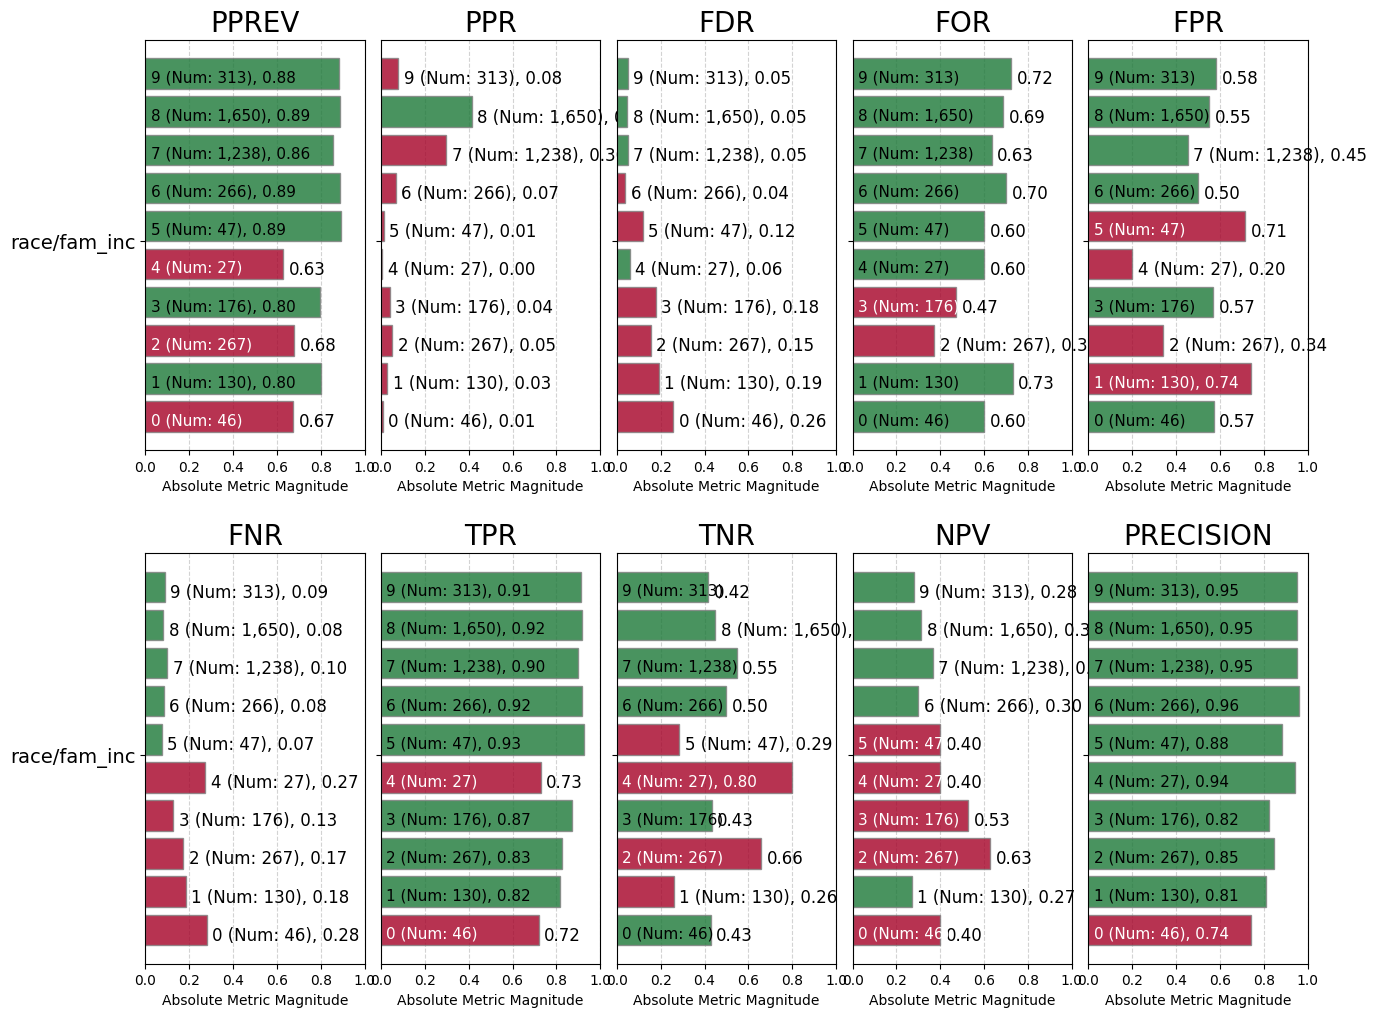

{'race/fam_inc': ['white 4'], 'race/lsat': ['white Score >37'], 'lsat/fam_inc': ['Score >37 4']}
---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=9, min_samples_leaf=16)
[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Instantiating postprocessing Threshold.


INFO:methods.postprocessing.Threshold:Instantiating postprocessing Threshold.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Transforming predictions.


INFO:methods.postprocessing.Threshold:Transforming predictions.


[INFO] 2024-12-07 20:40:22 methods.postprocessing.Threshold - Finished transforming predictions.


INFO:methods.postprocessing.Threshold:Finished transforming predictions.


Accuracy score test corrected:
0.7793


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0   lsat/fam_inc               0      0.68  0.79  0.39  0.59  0.22  0.61   
1   lsat/fam_inc               1      0.75  0.84  0.38  0.64  0.15  0.62   
2   lsat/fam_inc               2      0.82  0.89  0.52  0.45  0.12  0.48   
3   lsat/fam_inc               3      0.81  0.87  0.47  0.61  0.10  0.53   
4   lsat/fam_inc               4      0.84  0.91  0.39  0.59  0.10  0.61   
5   lsat/fam_inc               5      0.85  0.96  0.00  1.00  0.12  1.00   
6   lsat/fam_inc               6      0.91  0.92  0.33  0.94  0.01  0.67   
7   lsat/fam_inc               7      0.90  0.93  0.38  0.77  0.04  0.62   
8   lsat/fam_inc               8      0.89  0.92  0.49  0.76  0.03  0.51   
9   lsat/fam_inc               9      0.92  0.95  0.36  0.73  0.04  0.64   

    fnr   npv  precision   ppr  pprev  prev  
0  0.21  0.41       0.78  0.01   0.74  0.73  
1  0.16  0.36       0.85  0.05   0.80  0.80  
2  0.11  0.55       0.88  0.18   0.81  0.79  
3  0.13  0.39       0.90  0.17   0.82  0.85  
4  0.09  0.41       0.90  0.03   0.87  0.86  
5  0.04  0.00       0.88  0.01   0.96  0.89  
6  0.08  0.06       0.99  0.05   0.91  0.98  
7  0.07  0.23       0.96  0.18   0.91  0.95  
8  0.08  0.24       0.97  0.27   0.89  0.95  
9  0.05  0.27       0.96  0.06   0.93  0.95

Majority class for:  lsat/fam_inc  is: 8
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  for_disparity  \
0   lsat/fam_inc               0           7.48           2.45           0.78   
1   lsat/fam_inc               1           5.06           1.90           0.84   
2   lsat/fam_inc               2           4.03           1.29           0.59   
3   lsat/fam_inc               3           3.29           1.55           0.80   
4   lsat/fam_inc               4           3.30           1.07           0.78   
5   lsat/fam_inc               5           3.84           0.49           1.32   
6   lsat/fam_inc               6           0.40           0.99           1.24   
7   lsat/fam_inc               7           1.23           0.87           1.02   
8   lsat/fam_inc               8           1.00           1.00           1.00   
9   lsat/fam_inc               9           1.18           0.64           0.97   

   fpr_disparity  npv_disparity  ppr_disparity  pprev_disparity  \
0           1.20           1.69           0.05             0.83   
1           1.22           1.49           0.18             0.89   
2           0.93           2.27           0.66             0.90   
3           1.03           1.62           0.63             0.91   
4           1.20           1.69           0.11             0.97   
5           1.97           0.00           0.03             1.08   
6           1.31           0.26           0.17             1.02   
7           1.21           0.95           0.67             1.02   
8           1.00           1.00           1.00             1.00   
9           1.25           1.10           0.20             1.04   

   precision_disparity  tnr_disparity  tpr_disparity  
0                 0.80           0.79           0.87  
1                 0.87           0.78           0.92  
2                 0.91           1.07           0.97  
3                 0.93           0.96           0.95  
4                 0.93           0.79           0.99  
5                 0.91           0.00           1.05  
6                 1.02           0.68           1.00  
7                 0.99           0.78           1.01  
8                 1.00           1.00           1.00  
9                 0.99           0.74           1.03

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc            NaN            NaN            NaN            NaN
race/lsat               NaN            NaN            NaN            NaN
lsat/fam_inc          1.225          1.232           0.37          0.759
Overall average for fnr_disparity:  1.225
Overall average for fpr_disparity:  1.232
Overall average for ppr_disparity:  0.370
Overall average for tnr_disparity:  0.759


<Figure size 640x480 with 0 Axes>

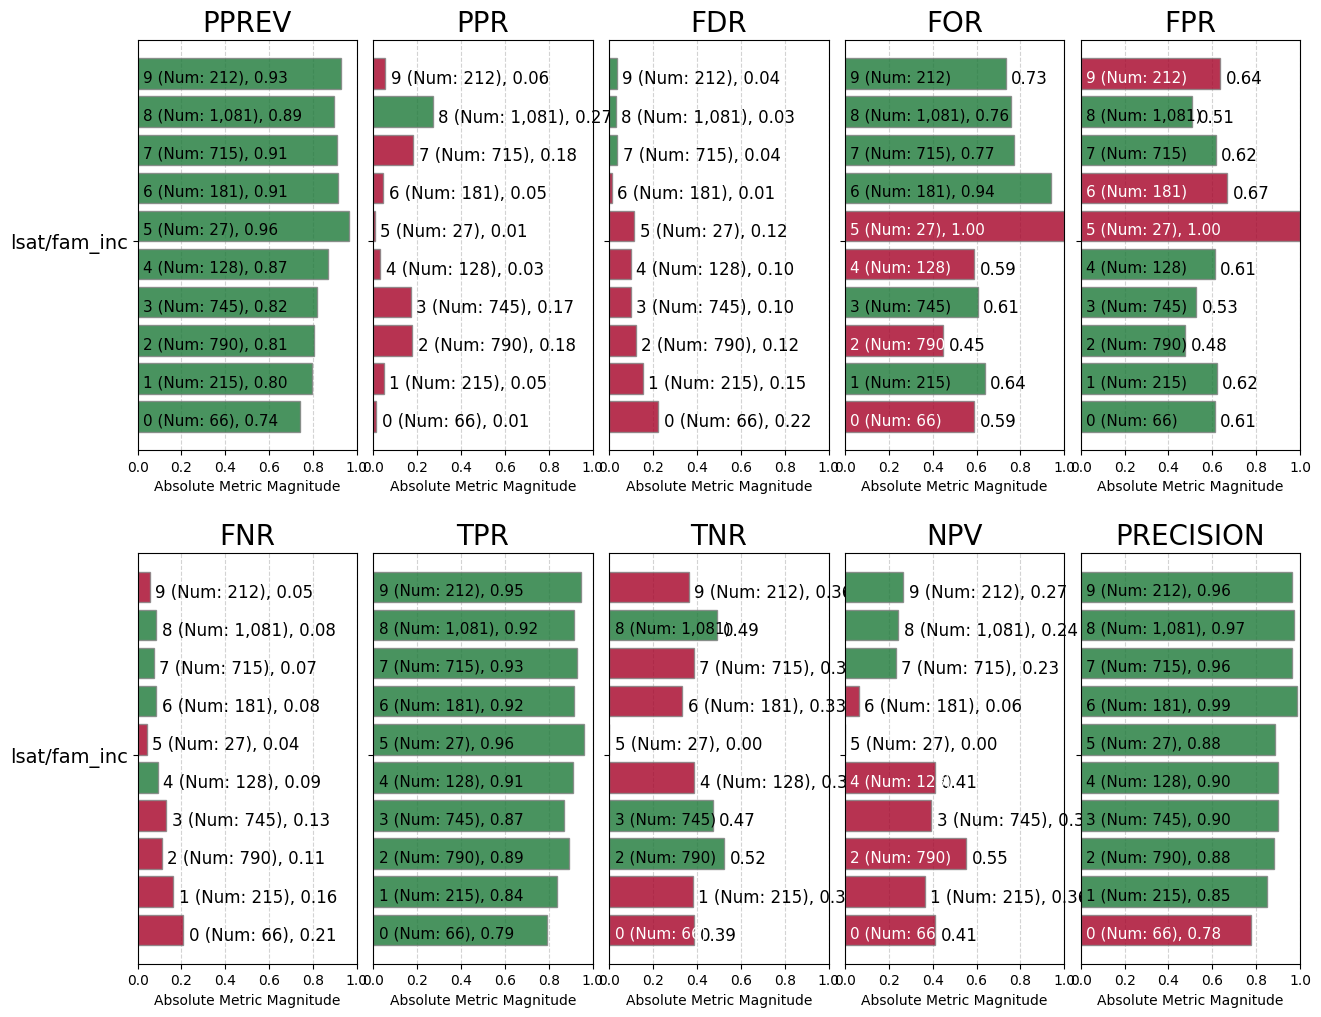

<Figure size 640x480 with 0 Axes>

In [55]:
df_test_aequitas = post_process_group_threshold_aequitas(data_to_transform, 'race/lsat', target,list_of_disparities, priv,"DecisionTree",[])
df_test_aequitas = post_process_group_threshold_aequitas(data_to_transform, 'race/fam_inc', target, list_of_disparities, priv,"DecisionTree",[])
df_test_aequitas = post_process_group_threshold_aequitas(data_to_transform, 'lsat/fam_inc', target,list_of_disparities, priv,"DecisionTree",[])

In [56]:
post_process_eq_ods(data=data_to_transform, attributes=protected_attributes_int, target=target, list_of_disparities=list_of_disparities, priv=priv, model="DecisionTree", to_encode=[])

---------- Model name:  DecisionTree ----------

Best estimator: DecisionTreeClassifier(max_depth=9, min_samples_leaf=16)
Privileged groups:  [{'race/fam_inc': 8}]
Unprivileged groups:  [{'race/fam_inc': 4}, {'race/fam_inc': 0}, {'race/fam_inc': 5}, {'race/fam_inc': 1}, {'race/fam_inc': 3}, {'race/fam_inc': 6}, {'race/fam_inc': 2}, {'race/fam_inc': 9}, {'race/fam_inc': 7}]
Accuracy score test corrected:
0.8851


attribute_name attribute_value  accuracy   tpr   tnr   for   fdr   fpr  \
0    race/fam_inc               0      0.67  0.91  0.14  0.60  0.29  0.86   
1    race/fam_inc               1      0.77  0.94  0.11  0.67  0.20  0.89   
2    race/fam_inc               2      0.68  0.93  0.11  0.59  0.30  0.89   
3    race/fam_inc               3      0.73  0.97  0.02  0.80  0.25  0.98   
4    race/fam_inc               4      0.81  1.00  0.00   NaN  0.19  1.00   
5    race/fam_inc               5      0.87  1.00  0.14  0.00  0.13  0.86   
6    race/fam_inc               6      0.93  1.00  0.06  0.50  0.06  0.94   
7    race/fam_inc               7      0.91  1.00  0.07  0.27  0.09  0.93   
8    race/fam_inc               8      0.92  0.99  0.09  0.60  0.07  0.91   
9    race/fam_inc               9      0.92  1.00  0.04  0.50  0.07  0.96   
10      race/lsat               0      0.64  0.91  0.10  0.63  0.34  0.90   
11      race/lsat               1      0.92  1.00  0.00   NaN  0.08  1.00   
12      race/lsat               2      0.87  0.99  0.10  0.47  0.12  0.90   
13      race/lsat               3      0.95  1.00  0.04  0.60  0.05  0.96   
14   lsat/fam_inc               0      0.73  0.94  0.17  0.50  0.25  0.83   
15   lsat/fam_inc               1      0.79  0.96  0.10  0.64  0.19  0.90   
16   lsat/fam_inc               2      0.80  0.97  0.10  0.48  0.19  0.90   
17   lsat/fam_inc               3      0.84  0.97  0.08  0.64  0.15  0.92   
18   lsat/fam_inc               4      0.86  0.99  0.06  0.50  0.13  0.94   
19   lsat/fam_inc               5      0.89  1.00  0.00   NaN  0.11  1.00   
20   lsat/fam_inc               6      0.98  1.00  0.00   NaN  0.02  1.00   
21   lsat/fam_inc               7      0.95  1.00  0.00   NaN  0.05  1.00   
22   lsat/fam_inc               8      0.95  0.99  0.07  0.60  0.05  0.93   
23   lsat/fam_inc               9      0.95  1.00  0.00   NaN  0.05  1.00   

     fnr   npv  precision   ppr  pprev  prev  
0   0.09  0.40       0.71  0.01   0.89  0.70  
1   0.06  0.33       0.80  0.03   0.93  0.79  
2   0.07  0.41       0.70  0.06   0.92  0.69  
3   0.03  0.20       0.75  0.04   0.97  0.75  
4   0.00   NaN       0.81  0.01   1.00  0.81  
5   0.00  1.00       0.87  0.01   0.98  0.85  
6   0.00  0.50       0.94  0.06   0.99  0.93  
7   0.00  0.73       0.91  0.30   0.99  0.90  
8   0.01  0.40       0.93  0.40   0.98  0.92  
9   0.00  0.50       0.93  0.08   0.99  0.92  
10  0.09  0.37       0.66  0.10   0.91  0.66  
11  0.00   NaN       0.92  0.05   1.00  0.92  
12  0.01  0.53       0.88  0.36   0.98  0.87  
13  0.00  0.40       0.95  0.50   1.00  0.95  
14  0.06  0.50       0.75  0.01   0.91  0.73  
15  0.04  0.36       0.81  0.05   0.95  0.80  
16  0.03  0.52       0.81  0.19   0.96  0.79  
17  0.03  0.36       0.85  0.18   0.97  0.85  
18  0.01  0.50       0.87  0.03   0.98  0.86  
19  0.00   NaN       0.89  0.01   1.00  0.89  
20  0.00   NaN       0.98  0.04   1.00  0.98  
21  0.00   NaN       0.95  0.18   1.00  0.95  
22  0.01  0.40       0.95  0.26   0.99  0.95  
23  0.00   NaN       0.95  0.05   1.00  0.95

Majority class for:  race/fam_inc  is: 8
Majority class for:  race/lsat  is: 3
Majority class for:  lsat/fam_inc  is: 8
[]


attribute_name attribute_value  fdr_disparity  fnr_disparity  \
0    race/fam_inc               0           4.12           7.93   
1    race/fam_inc               1           2.79           4.93   
2    race/fam_inc               2           4.20           5.95   
3    race/fam_inc               3           3.54           2.56   
4    race/fam_inc               4           2.61           0.00   
5    race/fam_inc               5           1.84           0.00   
6    race/fam_inc               6           0.91           0.34   
7    race/fam_inc               7           1.27           0.23   
8    race/fam_inc               8           1.00           1.00   
9    race/fam_inc               9           1.04           0.29   
10      race/lsat               0           7.26          27.48   
11      race/lsat               1           1.75           0.00   
12      race/lsat               2           2.65           4.26   
13      race/lsat               3           1.00           1.00   
14   lsat/fam_inc               0           5.05          10.67   
15   lsat/fam_inc               1           3.76           6.91   
16   lsat/fam_inc               2           3.87           4.35   
17   lsat/fam_inc               3           2.95           4.33   
18   lsat/fam_inc               4           2.73           1.55   
19   lsat/fam_inc               5           2.25           0.00   
20   lsat/fam_inc               6           0.33           0.00   
21   lsat/fam_inc               7           1.10           0.00   
22   lsat/fam_inc               8           1.00           1.00   
23   lsat/fam_inc               9           1.05           0.00   

    for_disparity  fpr_disparity  npv_disparity  ppr_disparity  \
0            1.00           0.95           1.00           0.03   
1            1.11           0.98           0.83           0.07   
2            0.98           0.98           1.02           0.15   
3            1.33           1.08           0.50           0.11   
4             NaN           1.10            NaN           0.02   
5            0.00           0.95           2.50           0.03   
6            0.83           1.04           1.25           0.16   
7            0.45           1.03           1.82           0.76   
8            1.00           1.00           1.00           1.00   
9            0.83           1.06           1.25           0.19   
10           1.06           0.94           0.91           0.21   
11            NaN           1.04            NaN           0.09   
12           0.79           0.94           1.32           0.72   
13           1.00           1.00           1.00           1.00   
14           0.83           0.90           1.25           0.06   
15           1.06           0.97           0.91           0.19   
16           0.81           0.96           1.29           0.71   
17           1.07           0.99           0.90           0.67   
18           0.83           1.02           1.25           0.12   
19            NaN           1.08            NaN           0.03   
20            NaN           1.08            NaN           0.17   
21            NaN           1.08            NaN           0.67   
22           1.00           1.00           1.00           1.00   
23            NaN           1.08            NaN           0.20   

    pprev_disparity  precision_disparity  tnr_disparity  tpr_disparity  
0              0.91                 0.76           1.51           0.92  
1              0.95                 0.86           1.18           0.95  
2              0.93                 0.76           1.16           0.94  
3              0.99                 0.81           0.24           0.98  
4              1.02                 0.88           0.00           1.01  
5              1.00                 0.94           1.51           1.01  
6              1.01                 1.01           0.59           1.01  
7              1.01                 0.98           0.71           1.01  
8              1.00

dict_keys(['race/fam_inc', 'race/lsat', 'lsat/fam_inc'])
              fnr_disparity  fpr_disparity  ppr_disparity  tnr_disparity
race/fam_inc          2.323          1.017          0.252          0.834
race/lsat             8.185          0.980          0.505          1.425
lsat/fam_inc          2.881          1.016          0.382          0.815
Overall average for fnr_disparity:  4.463
Overall average for fpr_disparity:  1.004
Overall average for ppr_disparity:  0.380
Overall average for tnr_disparity:  1.025


score  label_value race/fam_inc race/lsat lsat/fam_inc  rank_abs  \
20386    1.0            1            6         3            6         1   
3828     1.0            1            6         3            6         2   
12021    1.0            1            1         0            1         3   
8041     1.0            1            8         3            8         4   
9783     1.0            1            8         2            3         5   
...      ...          ...          ...       ...          ...       ...   
8755     0.0            0            8         2            3      4156   
17360    0.0            0            8         3            8      4157   
18849    0.0            0            7         2            2      4158   
17714    0.0            1            2         0            2      4159   
19583    0.0            1            2         0            2      4160   

       rank_pct  binary_score  binary_fpr  binary_fnr  binary_for  binary_ppr  \
20386  0.000240             1         0.0         NaN         NaN           1   
3828   0.000481             1         0.0         NaN         NaN           1   
12021  0.000721             1         0.0         NaN         NaN           1   
8041   0.000962             1         0.0         NaN         NaN           1   
9783   0.001202             1         0.0         NaN         NaN           1   
...         ...           ...         ...         ...         ...         ...   
8755   0.999038             0         NaN         0.0         0.0           0   
17360  0.999279             0         NaN         0.0         0.0           0   
18849  0.999519             0         NaN         0.0         0.0           0   
17714  0.999760             0         NaN         1.0         1.0           0   
19583  1.000000             0         NaN         1.0         1.0           0   

       binary_tnr  binary_precision  binary_pprev  binary_fdr  binary_npv  \
20386         0.0               0.0             1         0.0         NaN   
3828          0.0               0.0             1         0.0         NaN   
12021         0.0               0.0             1         0.0         NaN   
8041          0.0               0.0             1         0.0         NaN   
9783          0.0               0.0             1         0.0         NaN   
...           ...               ...           ...         ...         ...   
8755          NaN               NaN             0         NaN         0.0   
17360         NaN               NaN             0         NaN         0.0   
18849         NaN               NaN             0         NaN         0.0   
17714         NaN               NaN             0         NaN         1.0   
19583         NaN               NaN             0         NaN         1.0   

       binary_tpr  
20386         NaN  
3828          NaN  
12021         NaN  
8041          NaN  
9783          NaN  
...           ...  
8755          0.0  
17360         0.0  
18849         0.0  
17714         1.0  
19583         1.0  

[4160 rows x 18 columns]

<Figure size 640x480 with 0 Axes>

x